In [234]:
!pip install plotly_express
!pip install geopy

import pandas as pd
import numpy as np
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly_express as px
import tqdm
from tqdm.notebook import tqdm_notebook
from matplotlib.colors import ListedColormap,LinearSegmentedColormap


# Import Data


In [236]:
# Use this Section to import the data files provided in the project folder.

# NETWORK KPI
# Location: Milan ; Reference month: either January, February or March 2020:

file_path = ''

#If executed in Colab, there is no need to put any file_path, just import the files in the enviroment

# KPIs
data_January = pd.read_csv(file_path+'Milano_800_January_MRN.csv') # Here January is selected
data_January.drop(['Unnamed: 0'], axis=1, inplace=True)
data_January['Date'] = pd.to_datetime(data_January['Date'])


data_February = pd.read_csv(file_path+'Milano_800_February_MRN.csv') # Here January is selected
data_February.drop(['Unnamed: 0'], axis=1, inplace=True)
data_February['Date'] = pd.to_datetime(data_February['Date'])

data_March = pd.read_csv(file_path+'Milano_800_March_MRN.csv') # Here January is selected
data_March.drop(['Unnamed: 0'], axis=1, inplace=True)
data_March['Date'] = pd.to_datetime(data_March['Date'])


# Cells Location:
locations = pd.read_csv(file_path+'Coordinates_MILANO.csv')





In [238]:
# We can see that more CELL are referred to the same ENODE; we decided eventually for consistency to use ENODEB summing the DL and UL of cells referred to the same ENODEB

locations.drop_duplicates(subset="ECELL_ID")

ENODEB_ID  \
0    930b285c764e554f338f671864b30d3941935b00   
1    930b285c764e554f338f671864b30d3941935b00   
2    930b285c764e554f338f671864b30d3941935b00   
3    930b285c764e554f338f671864b30d3941935b00   
4    930b285c764e554f338f671864b30d3941935b00   
..                                        ...   
957  3fdbc872d547a3c5b6404cb90960ed717085fa0b   
958  3fdbc872d547a3c5b6404cb90960ed717085fa0b   
959  3fdbc872d547a3c5b6404cb90960ed717085fa0b   
960  3fdbc872d547a3c5b6404cb90960ed717085fa0b   
961  b6f8bbfb91b95b0772431f9add1a113c2cfd8c3e   

                                     ECELL_ID    LONG_X      LAT_Y  
0    b7de6cd46e855aaec8e28b26d1767e7a738819db  9.208433  45.445358  
1    3821116bcdc789c9d54369ddd58b8e75fafdcb59  9.208433  45.445358  
2    9ed9d0f30e21c0218c987496c433e11dd611c9d2  9.208433  45.445358  
3    9ba7c2a7f2ae3a32003cd92d0ce82fdd734f1d7f  9.208433  45.445358  
4    ce8ca39728288e4065ec86b14e902807327427ff  9.208433  45.445358  
..                                        ...       ...        ...  
957  3b99faafa552a3deb33f45826e79bec090cc4084  9.158972  45.505527  
958  2be222cdb25c37650735f9a18e575cdaec91e995  9.158972  45.505527  
959  5d0ba788e727644a8aeecdc64f230a63b1465c66  9.158972  45.505527  
960  f16a9dacc5b0409172f4c710cbffff5dc4d89210  9.158972  45.505527  
961  ab05b6eaff14492668c10a0c3910bda656481071  9.191967  45.461388  

[962 rows x 4 columns]

In [239]:
#In this section we control the numbers of cells for each month, to have the same
#dataset in every period

january_cells = []
january_cells_id = data_January["ECELL_ID"].to_list()
for i in range(len(january_cells_id)):
    if not (january_cells_id[i] in january_cells):
        january_cells.append(january_cells_id[i])
len(january_cells)

398

In [240]:
february_cells = []
february_cells_id = data_February["ECELL_ID"].to_list()
for i in range(len(february_cells_id)):
    if not (february_cells_id[i] in february_cells):
        february_cells.append(february_cells_id[i])
len(february_cells)

395

In [241]:
march_cells = []
march_cells_id = data_March["ECELL_ID"].to_list()
for i in range(len(march_cells_id)):
    if not (march_cells_id[i] in march_cells):
        march_cells.append(march_cells_id[i])
len(march_cells)

395

In [242]:
counter_diff = 0
for i in february_cells:
    if i not in march_cells:
      counter_diff = counter_diff + 1
      february_cells.remove(i)
counter_diff


0

In [243]:
#Identification and removal of the 3 E-CELLS of January which are not present in February and March

counter_diff = 0
arr_to_delete = []
for i in january_cells:
    if i not in february_cells:
      counter_diff = counter_diff + 1
      arr_to_delete.append(i)

for i in arr_to_delete:
  data_January= data_January[data_January.ECELL_ID != i]
  if i in january_cells:
    january_cells.remove(i)

In [244]:
#In each dataset, there are now 395 cells; in the locations dataset, there are 962. We delete the cells without data

for i in locations.ECELL_ID:
  if i not in january_cells:
    locations = locations[locations.ECELL_ID != i]

locations


ENODEB_ID  \
0    930b285c764e554f338f671864b30d3941935b00   
1    930b285c764e554f338f671864b30d3941935b00   
2    930b285c764e554f338f671864b30d3941935b00   
12   b1184e88a14997cf01299b13908568d949a1be53   
13   b1184e88a14997cf01299b13908568d949a1be53   
..                                        ...   
950  f161d41795890db558d3e34b6ddd61bda77e8764   
951  f161d41795890db558d3e34b6ddd61bda77e8764   
955  3fdbc872d547a3c5b6404cb90960ed717085fa0b   
956  3fdbc872d547a3c5b6404cb90960ed717085fa0b   
957  3fdbc872d547a3c5b6404cb90960ed717085fa0b   

                                     ECELL_ID    LONG_X      LAT_Y  
0    b7de6cd46e855aaec8e28b26d1767e7a738819db  9.208433  45.445358  
1    3821116bcdc789c9d54369ddd58b8e75fafdcb59  9.208433  45.445358  
2    9ed9d0f30e21c0218c987496c433e11dd611c9d2  9.208433  45.445358  
12   cdff26a5c4ce73ee8aef8684045e74727f395bf5  9.227019  45.463230  
13   01e15165b5683c9f4922e7ffdc82471e479e7779  9.227019  45.463230  
..                                        ...       ...        ...  
950  dfee8b67dd0f806325484e2fd32e1bdcb93bd491  9.175056  45.460056  
951  963d7b7a00e2b9c7d20fe313dced0388be5b4dac  9.175056  45.460056  
955  8c203d8b0fb924503c6af744f2035aa43867d1fb  9.158972  45.505527  
956  82a9f5269531147ac5ce15ff92fd8172d1ff0bcf  9.158972  45.505527  
957  3b99faafa552a3deb33f45826e79bec090cc4084  9.158972  45.505527  

[395 rows x 4 columns]

In [245]:
#It's time to take only the useful data. We chose UL and DL traffic; different cells will be grouped by the same ENODEB

df_Jan = data_January.join(locations.set_index('ECELL_ID'), on='ECELL_ID')
df_Jan = df_Jan[['Date','ENODEB_ID', 'DL_VOL', 'UL_VOL']]
df_Jan = df_Jan.groupby(['Date', 'ENODEB_ID'], as_index = False)[['DL_VOL', 'UL_VOL']].sum()

df_Feb = data_February.join(locations.set_index('ECELL_ID'), on='ECELL_ID')
df_Feb = df_Feb[['Date','ENODEB_ID', 'DL_VOL', 'UL_VOL']]
df_Feb = df_Feb.groupby(['Date', 'ENODEB_ID'], as_index = False)[['DL_VOL', 'UL_VOL']].sum()

df_Mar= data_March.join(locations.set_index('ECELL_ID'), on='ECELL_ID')
df_Mar = df_Mar[['Date','ENODEB_ID', 'DL_VOL', 'UL_VOL']]
df_Mar = df_Mar.groupby(['Date', 'ENODEB_ID'], as_index = False)[['DL_VOL', 'UL_VOL']].sum()

In [293]:
#Just for clarity, plot of the locations of each base station on a map of Milan

px.set_mapbox_access_token("pk.eyJ1IjoiY2hpYXJhZHJhZ2hpbmkiLCJhIjoiY2tzdWhlY2YyMGN2czJwcHV2dWt5cXFlcCJ9.bzW271vEA_agKVY5K2FvGA")

fig = px.scatter_mapbox(locations, lat="LAT_Y", lon="LONG_X", zoom=10, hover_data =[locations.ENODEB_ID])
fig.show()




# Data Pre-Processing

In [248]:
# January

# We create the dictionary week_January, with 7 keys equal to the week days.
# Each element is a pandas dataframe with the data of each cells, one for hour, in the mondays, tuesdays ecc
# We decided to select the 3 weeks from 6th to 27th of January

#January is a big dataframe containing everything. It will be useful later


week_January = {}
week_January.setdefault('Monday',{})
week_January.setdefault('Tuesday',{})
week_January.setdefault('Wednesday',{})
week_January.setdefault('Thursday',{})
week_January.setdefault('Friday',{})
week_January.setdefault('Saturday',{})
week_January.setdefault('Sunday',{})

week_January['Monday'] = pd.DataFrame()
week_January['Tuesday'] = pd.DataFrame()
week_January['Wednesday'] = pd.DataFrame()
week_January['Thursday'] = pd.DataFrame()
week_January['Friday'] = pd.DataFrame()
week_January['Saturday'] = pd.DataFrame()
week_January['Sunday'] = pd.DataFrame()

January = pd.DataFrame()

month_start = 6
month_end = 27
while month_start < month_end:
  if (month_start%7 == 6):
    monday = df_Jan[df_Jan['Date'] < pd.Timestamp(year=2020, month=1, day=month_start+1, hour = 0, minute =1)]
    monday = monday[monday['Date'] > pd.Timestamp(year=2020, month=1, day=month_start-1, hour = 23, minute =59)]
    week_January['Monday'] = pd.concat([week_January['Monday'], monday], ignore_index=True)
  if (month_start%7 == 0):
    tuesday = df_Jan[df_Jan['Date'] < pd.Timestamp(year=2020, month=1, day=month_start+1, hour = 0, minute =1)]
    tuesday = tuesday[tuesday['Date'] > pd.Timestamp(year=2020, month=1, day=month_start-1, hour = 23, minute =59)]
    week_January['Tuesday'] = pd.concat([week_January['Tuesday'], tuesday], ignore_index=True)
  if (month_start%7 == 1):
    wednesday = df_Jan[df_Jan['Date'] < pd.Timestamp(year=2020, month=1, day=month_start+1, hour = 0, minute =1)]
    wednesday = wednesday[wednesday['Date'] > pd.Timestamp(year=2020, month=1, day=month_start-1, hour = 23, minute =59)]
    week_January['Wednesday'] = pd.concat([week_January['Wednesday'], wednesday], ignore_index=True)
  if (month_start%7 == 2):
    thursday = df_Jan[df_Jan['Date'] < pd.Timestamp(year=2020, month=1, day=month_start+1, hour = 0, minute =1)]
    thursday = thursday[thursday['Date'] > pd.Timestamp(year=2020, month=1, day=month_start-1, hour = 23, minute =59)]
    week_January['Thursday'] = pd.concat([week_January['Thursday'], thursday], ignore_index=True)
  if (month_start%7 == 3):
    friday = df_Jan[df_Jan['Date'] < pd.Timestamp(year=2020, month=1, day=month_start+1, hour = 0, minute =1)]
    friday = friday[friday['Date'] > pd.Timestamp(year=2020, month=1, day=month_start-1, hour = 23, minute =59)]
    week_January['Friday'] = pd.concat([week_January['Friday'], friday], ignore_index=True)
  if (month_start%7 == 4):
    saturday = df_Jan[df_Jan['Date'] < pd.Timestamp(year=2020, month=1, day=month_start+1, hour = 0, minute =1)]
    saturday = saturday[saturday['Date'] > pd.Timestamp(year=2020, month=1, day=month_start-1, hour = 23, minute =59)]
    week_January['Saturday'] = pd.concat([week_January['Saturday'], saturday], ignore_index=True)
  if (month_start%7 == 5):
    sunday = df_Jan[df_Jan['Date'] < pd.Timestamp(year=2020, month=1, day=month_start+1, hour = 0, minute =1)]
    sunday = sunday[sunday['Date'] > pd.Timestamp(year=2020, month=1, day=month_start-1, hour = 23, minute =59)]
    week_January['Sunday'] = pd.concat([week_January['Sunday'], sunday], ignore_index=True)
  month_start = month_start + 1

January = pd.concat([week_January['Monday'],week_January['Tuesday'],week_January['Wednesday'],week_January['Thursday'],week_January['Friday'],week_January['Saturday'],week_January['Sunday']],ignore_index=True).sort_values(by='Date')


In [249]:
# February

#As for January, the same idea is used for February. The starting day is 3rd and the last day is 29th of February

week_February = {}
week_February.setdefault('Monday',{})
week_February.setdefault('Tuesday',{})
week_February.setdefault('Wednesday',{})
week_February.setdefault('Thursday',{})
week_February.setdefault('Friday',{})
week_February.setdefault('Saturday',{})
week_February.setdefault('Sunday',{})

week_February['Monday'] = pd.DataFrame()
week_February['Tuesday'] = pd.DataFrame()
week_February['Wednesday'] = pd.DataFrame()
week_February['Thursday'] = pd.DataFrame()
week_February['Friday'] = pd.DataFrame()
week_February['Saturday'] = pd.DataFrame()
week_February['Sunday'] = pd.DataFrame()

February = pd.DataFrame()

month_start = 3
month_end = 29
while month_start < month_end:
  if (month_start%7 == 3):
    monday = df_Feb[df_Feb['Date'] < pd.Timestamp(year=2020, month=2, day=month_start+1, hour = 0, minute =1)]
    monday = monday[monday['Date'] > pd.Timestamp(year=2020, month=2, day=month_start-1, hour = 23, minute =59)]
    week_February['Monday'] = pd.concat([week_February['Monday'], monday], ignore_index=True)
  if (month_start%7 == 4):
    tuesday = df_Feb[df_Feb['Date'] < pd.Timestamp(year=2020, month=2, day=month_start+1, hour = 0, minute =1)]
    tuesday = tuesday[tuesday['Date'] > pd.Timestamp(year=2020, month=2, day=month_start-1, hour = 23, minute =59)]
    week_February['Tuesday'] = pd.concat([week_February['Tuesday'], tuesday], ignore_index=True)
  if (month_start%7 == 5):
    wednesday = df_Feb[df_Feb['Date'] < pd.Timestamp(year=2020, month=2, day=month_start+1, hour = 0, minute =1)]
    wednesday = wednesday[wednesday['Date'] > pd.Timestamp(year=2020, month=2, day=month_start-1, hour = 23, minute =59)]
    week_February['Wednesday'] = pd.concat([week_February['Wednesday'], wednesday], ignore_index=True)
  if (month_start%7 == 6):
    thursday = df_Feb[df_Feb['Date'] < pd.Timestamp(year=2020, month=2, day=month_start+1, hour = 0, minute =1)]
    thursday = thursday[thursday['Date'] > pd.Timestamp(year=2020, month=2, day=month_start-1, hour = 23, minute =59)]
    week_February['Thursday'] = pd.concat([week_February['Thursday'], thursday], ignore_index=True)
  if (month_start%7 == 0):
    friday = df_Feb[df_Feb['Date'] < pd.Timestamp(year=2020, month=2, day=month_start+1, hour = 0, minute =1)]
    friday = friday[friday['Date'] > pd.Timestamp(year=2020, month=2, day=month_start-1, hour = 23, minute =59)]
    week_February['Friday'] = pd.concat([week_February['Friday'], friday], ignore_index=True)
  if (month_start%7 == 1):
    saturday = df_Feb[df_Feb['Date'] < pd.Timestamp(year=2020, month=2, day=month_start+1, hour = 0, minute =1)]
    saturday = saturday[saturday['Date'] > pd.Timestamp(year=2020, month=2, day=month_start-1, hour = 23, minute =59)]
    week_February['Saturday'] = pd.concat([week_February['Saturday'], saturday], ignore_index=True)
  if (month_start%7 == 2):
    sunday = df_Feb[df_Feb['Date'] < pd.Timestamp(year=2020, month=2, day=month_start+1, hour = 0, minute =1)]
    sunday = sunday[sunday['Date'] > pd.Timestamp(year=2020, month=2, day=month_start-1, hour = 23, minute =59)]
    week_February['Sunday'] = pd.concat([week_February['Sunday'], sunday], ignore_index=True)
  month_start = month_start + 1

February = pd.concat([week_February['Monday'],week_February['Tuesday'],week_February['Wednesday'],week_February['Thursday'],week_February['Friday'],week_February['Saturday'],week_February['Sunday']],ignore_index=True).sort_values(by='Date')

In [251]:
# March

#Same idea as before

week_March = {}
week_March.setdefault('Monday',{})
week_March.setdefault('Tuesday',{})
week_March.setdefault('Wednesday',{})
week_March.setdefault('Thursday',{})
week_March.setdefault('Friday',{})
week_March.setdefault('Saturday',{})
week_March.setdefault('Sunday',{})

week_March['Monday'] = pd.DataFrame()
week_March['Tuesday'] = pd.DataFrame()
week_March['Wednesday'] = pd.DataFrame()
week_March['Thursday'] = pd.DataFrame()
week_March['Friday'] = pd.DataFrame()
week_March['Saturday'] = pd.DataFrame()
week_March['Sunday'] = pd.DataFrame()

March = pd.DataFrame()

month_start = 2
month_end = 29
while month_start < month_end:
  if (month_start%7 == 6):
    monday = df_Mar[df_Mar['Date'] < pd.Timestamp(year=2020, month=3, day=month_start+1, hour = 0, minute =1)]
    monday = monday[monday['Date'] > pd.Timestamp(year=2020, month=3, day=month_start-1, hour = 23, minute =59)]
    week_March['Monday'] = pd.concat([week_March['Monday'], monday], ignore_index=True)
  if (month_start%7 == 0):
    tuesday = df_Mar[df_Mar['Date'] < pd.Timestamp(year=2020, month=3, day=month_start+1, hour = 0, minute =1)]
    tuesday = tuesday[tuesday['Date'] > pd.Timestamp(year=2020, month=3, day=month_start-1, hour = 23, minute =59)]
    week_March['Tuesday'] = pd.concat([week_March['Tuesday'], tuesday], ignore_index=True)
  if (month_start%7 == 1):
    wednesday = df_Mar[df_Mar['Date'] < pd.Timestamp(year=2020, month=3, day=month_start+1, hour = 0, minute =1)]
    wednesday = wednesday[wednesday['Date'] > pd.Timestamp(year=2020, month=3, day=month_start-1, hour = 23, minute =59)]
    week_March['Wednesday'] = pd.concat([week_March['Wednesday'], wednesday], ignore_index=True)
  if (month_start%7 == 2):
    thursday = df_Mar[df_Mar['Date'] < pd.Timestamp(year=2020, month=3, day=month_start+1, hour = 0, minute =1)]
    thursday = thursday[thursday['Date'] > pd.Timestamp(year=2020, month=3, day=month_start-1, hour = 23, minute =59)]
    week_March['Thursday'] = pd.concat([week_March['Thursday'], thursday], ignore_index=True)
  if (month_start%7 == 3):
    friday = df_Mar[df_Mar['Date'] < pd.Timestamp(year=2020, month=3, day=month_start+1, hour = 0, minute =1)]
    friday = friday[friday['Date'] > pd.Timestamp(year=2020, month=3, day=month_start-1, hour = 23, minute =59)]
    week_March['Friday'] = pd.concat([week_March['Friday'], friday], ignore_index=True)
  if (month_start%7 == 4):
    saturday = df_Mar[df_Mar['Date'] < pd.Timestamp(year=2020, month=3, day=month_start+1, hour = 0, minute =1)]
    saturday = saturday[saturday['Date'] > pd.Timestamp(year=2020, month=3, day=month_start-1, hour = 23, minute =59)]
    week_March['Saturday'] = pd.concat([week_March['Saturday'], saturday], ignore_index=True)
  if (month_start%7 == 5):
    sunday = df_Mar[df_Mar['Date'] < pd.Timestamp(year=2020, month=3, day=month_start+1, hour = 0, minute =1)]
    sunday = sunday[sunday['Date'] > pd.Timestamp(year=2020, month=3, day=month_start-1, hour = 23, minute =59)]
    week_March['Sunday'] = pd.concat([week_March['Sunday'], sunday], ignore_index=True)
  month_start = month_start + 1

March = pd.concat([week_March['Monday'],week_March['Tuesday'],week_March['Wednesday'],week_March['Thursday'],week_March['Friday'],week_March['Saturday'],week_March['Sunday']],ignore_index=True).sort_values(by='Date')

In [252]:
#It's time to process the data; as suggested, the Downlink volume is used to create the median signature of the week.
#For each enodeB, it's created a Dataframe in the dictionary Downlink_January with Key equals to the enodeB ID. Same operation for February and March
#NOTE: it will take some time

downlink_January = {}
for j in week_January:
  for i in locations.ENODEB_ID:
    downlink_January.setdefault(i,{})
    downlink_January[i][j] = pd.DataFrame()
    downlink_January[i][j] = pd.concat([downlink_January[i][j],week_January[j].loc[week_January[j]['ENODEB_ID']==i,['Date','DL_VOL']]],ignore_index = True)


downlink_February = {}
for j in week_February:
  for i in locations.ENODEB_ID:
    downlink_February.setdefault(i,{})
    downlink_February[i][j] = pd.DataFrame()
    downlink_February[i][j] = pd.concat([downlink_February[i][j],week_February[j].loc[week_February[j]['ENODEB_ID']==i,['Date','DL_VOL']]],ignore_index = True)

downlink_March = {}
for j in week_March:
  for i in locations.ENODEB_ID:
    downlink_March.setdefault(i,{})
    downlink_March[i][j] = pd.DataFrame()
    downlink_March[i][j] = pd.concat([downlink_March[i][j],week_March[j].loc[week_March[j]['ENODEB_ID']==i,['Date','DL_VOL']]],ignore_index = True)



In [253]:
# The uplink is not neccessary for clustering, but it will be used for plotting more information; the reasoning is the same as the downlink

uplink_January = {}
for j in week_January:
  for i in locations.ENODEB_ID:
    uplink_January.setdefault(i,{})
    uplink_January[i][j] = pd.DataFrame()
    uplink_January[i][j] = pd.concat([uplink_January[i][j],week_January[j].loc[week_January[j]['ENODEB_ID']==i,['Date','UL_VOL']]],ignore_index = True)


uplink_February = {}
for j in week_February:
  for i in locations.ENODEB_ID:

    uplink_February.setdefault(i,{})
    uplink_February[i][j] = pd.DataFrame()
    uplink_February[i][j] = pd.concat([uplink_February[i][j],week_February[j].loc[week_February[j]['ENODEB_ID']==i,['Date','UL_VOL']]],ignore_index = True)

uplink_March = {}
for j in week_March:
  for i in locations.ENODEB_ID:

    uplink_March.setdefault(i,{})
    uplink_March[i][j] = pd.DataFrame()
    uplink_March[i][j] = pd.concat([uplink_March[i][j],week_March[j].loc[week_March[j]['ENODEB_ID']==i,['Date','UL_VOL']]],ignore_index = True)

In [254]:
#In each dataframe, the values are sorted in ascending order

for i in locations.ENODEB_ID:
  for j in week_January:
    downlink_January[i][j] = downlink_January[i][j].sort_values(by='Date')
    uplink_January[i][j] = uplink_January[i][j].sort_values(by='Date')
    downlink_February[i][j] = downlink_February[i][j].sort_values(by='Date')
    uplink_February[i][j] = uplink_February[i][j].sort_values(by='Date')
    downlink_March[i][j] = downlink_March[i][j].sort_values(by='Date')
    uplink_March[i][j] = uplink_March[i][j].sort_values(by='Date')

In [255]:
#Now it's time to compute the statistical value (median, mean and standard deviation, as suggested previously) to compute
#the weekly signature of each ENODE. In the dictionary statistic_January (same for February and March) there will be a dataframe
#with the statistical value of the cell, with key equals to the ENODEB
#In this way, it's created the signature for each day of the week for each cell, with the statistical values of each hour
#Same operation for February and March
#NOTE: it will take a lot of time

statistic_January = {}


for i in downlink_January:
  for j in week_January:
    divided_by_hour = downlink_January[i][j]
    divided_by_hour['Hour'] = divided_by_hour.Date.dt.hour
    median = divided_by_hour.groupby(['Hour']).median()
    avg = divided_by_hour.groupby(['Hour']).mean()
    std = divided_by_hour.groupby(['Hour']).std()
    statistic_January.setdefault(i,{})
    statistic_January[i][j] = pd.DataFrame(columns = ['Median','Average','Standard_Deviation'])
    statistic_January[i][j]['Median'] = median['DL_VOL']
    statistic_January[i][j]['Average'] = avg['DL_VOL']
    statistic_January[i][j]['Standard_Deviation'] = std['DL_VOL']

statistic_February = {}


for i in downlink_February:
  for j in week_February:
    divided_by_hour = downlink_February[i][j]
    divided_by_hour['Hour'] = divided_by_hour.Date.dt.hour
    median = divided_by_hour.groupby(['Hour']).median()
    avg = divided_by_hour.groupby(['Hour']).mean()
    std = divided_by_hour.groupby(['Hour']).std()

    statistic_February.setdefault(i,{})
    statistic_February[i][j] = pd.DataFrame(columns = ['Median','Average','Standard_Deviation'])
    statistic_February[i][j]['Median'] = median['DL_VOL']
    statistic_February[i][j]['Average'] = avg['DL_VOL']
    statistic_February[i][j]['Standard_Deviation'] = std['DL_VOL']


statistic_March = {}


for i in downlink_March:
  for j in week_March:
    divided_by_hour = downlink_March[i][j]
    divided_by_hour['Hour'] = divided_by_hour.Date.dt.hour
    median = divided_by_hour.groupby(['Hour']).median()
    avg = divided_by_hour.groupby(['Hour']).mean()
    std = divided_by_hour.groupby(['Hour']).std()

    statistic_March.setdefault(i,{})
    statistic_March[i][j] = pd.DataFrame(columns = ['Median','Average','Standard_Deviation'])
    statistic_March[i][j]['Median'] = median['DL_VOL']
    statistic_March[i][j]['Average'] = avg['DL_VOL']
    statistic_March[i][j]['Standard_Deviation'] = std['DL_VOL']




In [256]:
#For plotting reason, the same command are added for the uplink

statistic_January_uplink = {}


for i in uplink_January:
  for j in week_January:
    divided_by_hour = uplink_January[i][j]
    divided_by_hour['Hour'] = divided_by_hour.Date.dt.hour
    median = divided_by_hour.groupby(['Hour']).median()
    avg = divided_by_hour.groupby(['Hour']).mean()
    std = divided_by_hour.groupby(['Hour']).std()
    try:
      statistic_January_uplink[i][j]['Median'] = median['UL_VOL']
      statistic_January_uplink[i][j]['Average'] = avg['UL_VOL']
      statistic_January_uplink[i][j]['Standard_Deviation'] = std['UL_VOL']
    except:
      statistic_January_uplink.setdefault(i,{})
      statistic_January_uplink[i][j] = pd.DataFrame(columns = ['Median','Average','Standard_Deviation'])
      statistic_January_uplink[i][j]['Median'] = median['UL_VOL']
      statistic_January_uplink[i][j]['Average'] = avg['UL_VOL']
      statistic_January_uplink[i][j]['Standard_Deviation'] = std['UL_VOL']

statistic_February_uplink = {}


for i in uplink_February:
  for j in week_February:
    divided_by_hour = uplink_February[i][j]
    divided_by_hour['Hour'] = divided_by_hour.Date.dt.hour
    median = divided_by_hour.groupby(['Hour']).median()
    avg = divided_by_hour.groupby(['Hour']).mean()
    std = divided_by_hour.groupby(['Hour']).std()
    try:
      statistic_February_uplink[i][j]['Median'] = median['UL_VOL']
      statistic_February_uplink[i][j]['Average'] = avg['UL_VOL']
      statistic_February_uplink[i][j]['Standard_Deviation'] = std['UL_VOL']
    except:
      statistic_February_uplink.setdefault(i,{})
      statistic_February_uplink[i][j] = pd.DataFrame(columns = ['Median','Average','Standard_Deviation'])
      statistic_February_uplink[i][j]['Median'] = median['UL_VOL']
      statistic_February_uplink[i][j]['Average'] = avg['UL_VOL']
      statistic_February_uplink[i][j]['Standard_Deviation'] = std['UL_VOL']


statistic_March_uplink = {}


for i in uplink_March:
  for j in week_March:
    divided_by_hour = uplink_March[i][j]
    divided_by_hour['Hour'] = divided_by_hour.Date.dt.hour
    median = divided_by_hour.groupby(['Hour']).median()
    avg = divided_by_hour.groupby(['Hour']).mean()
    std = divided_by_hour.groupby(['Hour']).std()
    try:
      statistic_March_uplink[i][j]['Median'] = median['UL_VOL']
      statistic_March_uplink[i][j]['Average'] = avg['UL_VOL']
      statistic_March_uplink[i][j]['Standard_Deviation'] = std['UL_VOL']
    except:
      statistic_March_uplink.setdefault(i,{})
      statistic_March_uplink[i][j] = pd.DataFrame(columns = ['Median','Average','Standard_Deviation'])
      statistic_March_uplink[i][j]['Median'] = median['UL_VOL']
      statistic_March_uplink[i][j]['Average'] = avg['UL_VOL']
      statistic_March_uplink[i][j]['Standard_Deviation'] = std['UL_VOL']



In [260]:
#KMean Classification: now it's time to classify the different median weekly signature in the 3 categories

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#First thing first: the dataset is modified. Now in each row is stored the Median values of each hour, from Monday to Saturday.
#Each row, clearly, correspond to a given enodeB.

df_January = pd.DataFrame(columns = range(0,168))
cell_list = []
for i in statistic_January:
  temp = []
  cell_list.append(i)
  for j in statistic_January[i]:
    lista = list(statistic_January[i][j]['Median'])
    for k in lista:
      temp.append(k)
  df_January.loc[len(df_January.index)] = temp


#February

df_February = pd.DataFrame(columns = range(0,168))
for i in statistic_February:
  temp = []
  for j in statistic_February[i]:
    lista = list(statistic_February[i][j]['Median'])
    for k in lista:
      temp.append(k)

  df_February.loc[len(df_February.index)] = temp

#March

df_March = pd.DataFrame(columns = range(0,168))
for i in statistic_March:
  temp = []
  for j in statistic_March[i]:
    lista = list(statistic_March[i][j]['Median'])
    for k in lista:
      temp.append(k)

  df_March.loc[len(df_March.index)] = temp


In [261]:
#From the text, we already know there are 3 clusters: transport, residential, non-residential;

scaler = StandardScaler()
scaled_1 = scaler.fit_transform(df_January.T)
scaled = scaled_1.T
kmeans_model = KMeans(n_clusters=3, n_init = 'auto').fit(scaled)

kmeans_model.labels_

array([0, 0, 0, 0, 2, 0, 2, 1, 2, 0, 2, 2, 2, 0, 2, 0, 0, 2, 0, 2, 1, 0,
       2, 0, 1, 0, 0, 0, 2, 1, 2, 2, 1, 2, 2, 2, 1, 0, 1, 2, 1, 1, 0, 1,
       2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 2, 1, 0, 0, 2, 1, 1, 0, 1, 2,
       1, 0, 0, 0, 0, 1, 0, 0, 2, 1, 2, 1, 0, 2, 1, 1, 2, 0, 2, 0, 0, 2,
       0, 0, 1, 0, 1, 0, 2, 1, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2,
       0, 0, 1, 2, 2, 2], dtype=int32)

In [262]:
#The classifier has divided che various ENODEB in this way. Now it's time to analyze
#some samples of the group and decide which group is transport, residential and non residential

count_zero = 0
count_one = 0
count_two = 0
for i in kmeans_model.labels_:
  if i == 0:
    count_zero = count_zero + 1
  elif i == 1:
    count_one = count_one + 1
  elif i == 2:
    count_two = count_two + 1

print(count_zero)
print(count_one)
print(count_two)


56
40
42


In [263]:
list_zero = []
list_one = []
list_two = []

for i in range(len(kmeans_model.labels_)):
  if kmeans_model.labels_[i] == 0:
    list_zero.append(cell_list[i])
  elif kmeans_model.labels_[i] == 1:
    list_one.append(cell_list[i])
  elif kmeans_model.labels_[i] == 2:
    list_two.append(cell_list[i])



# Data Visualization

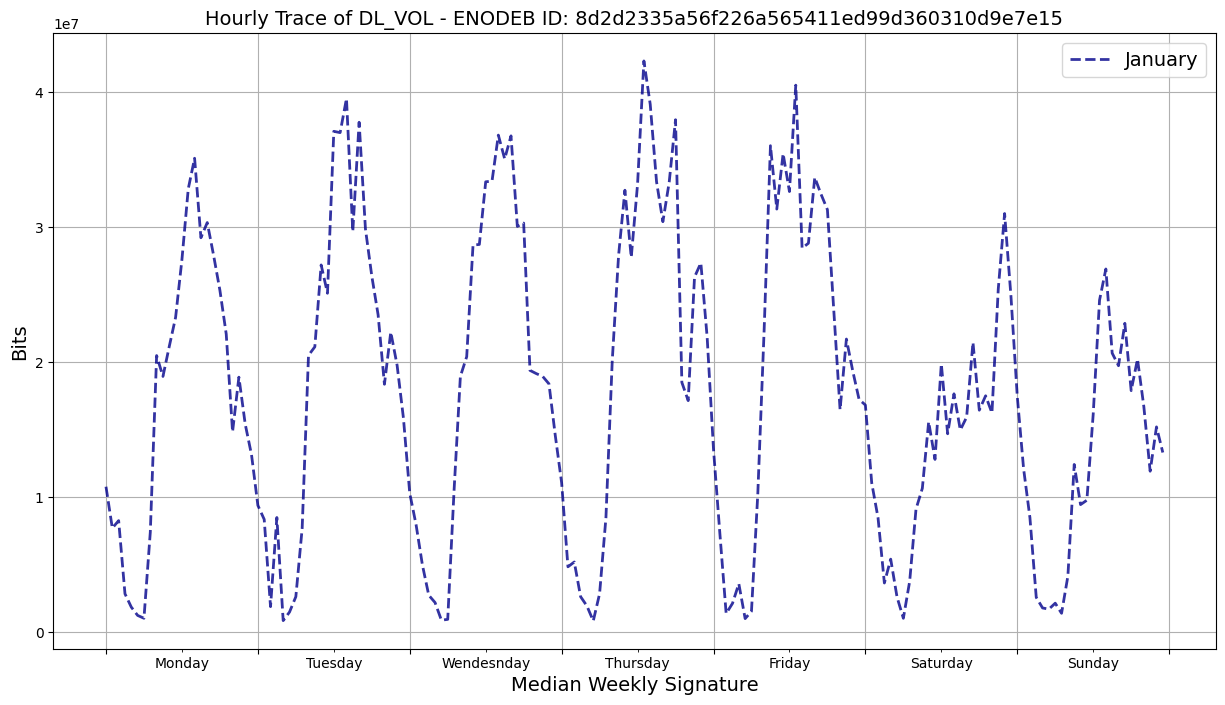

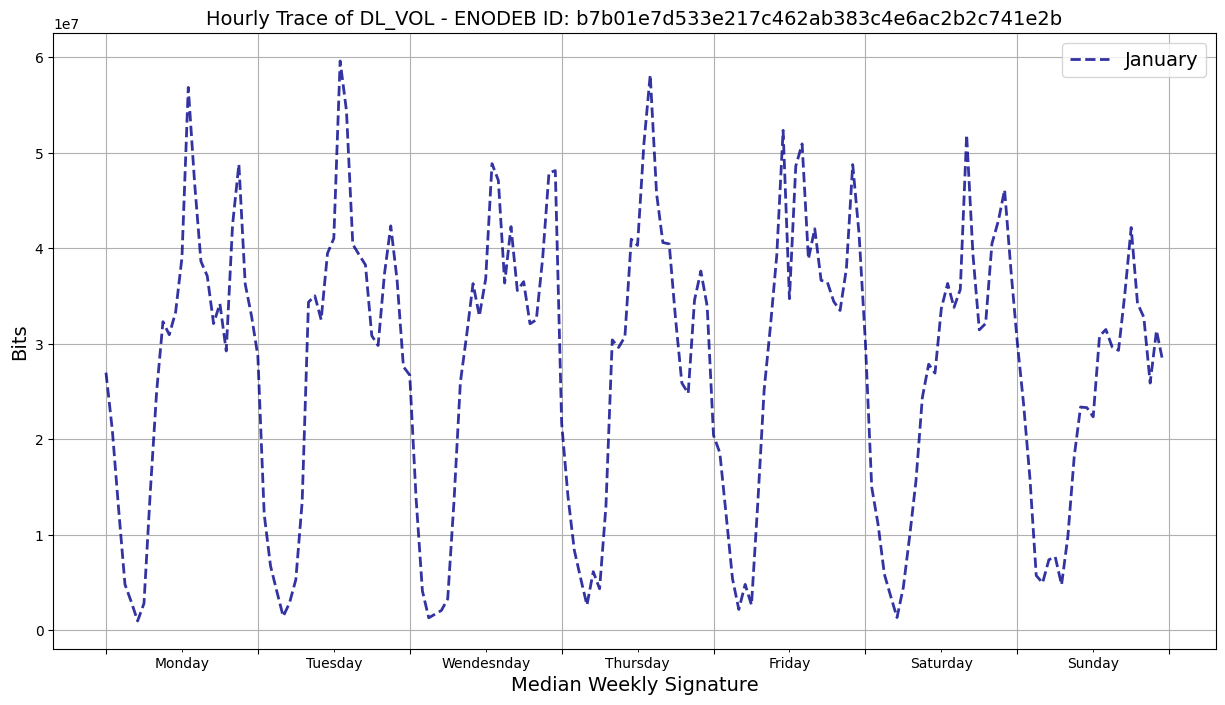

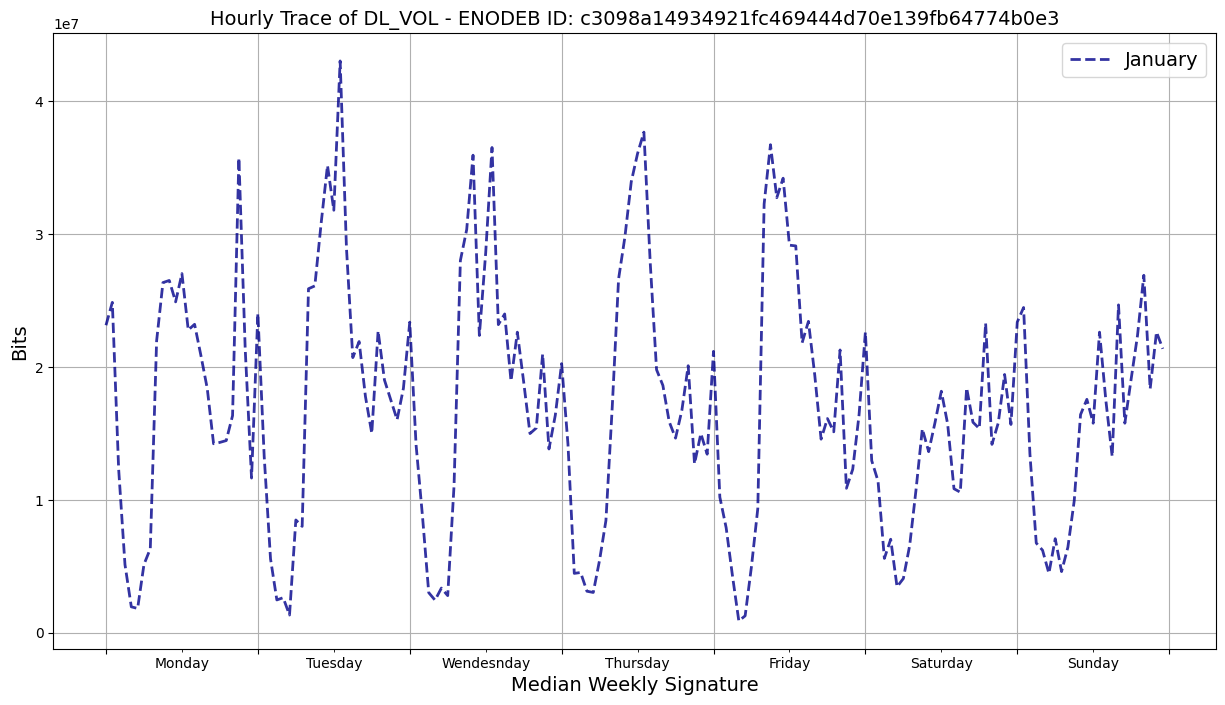

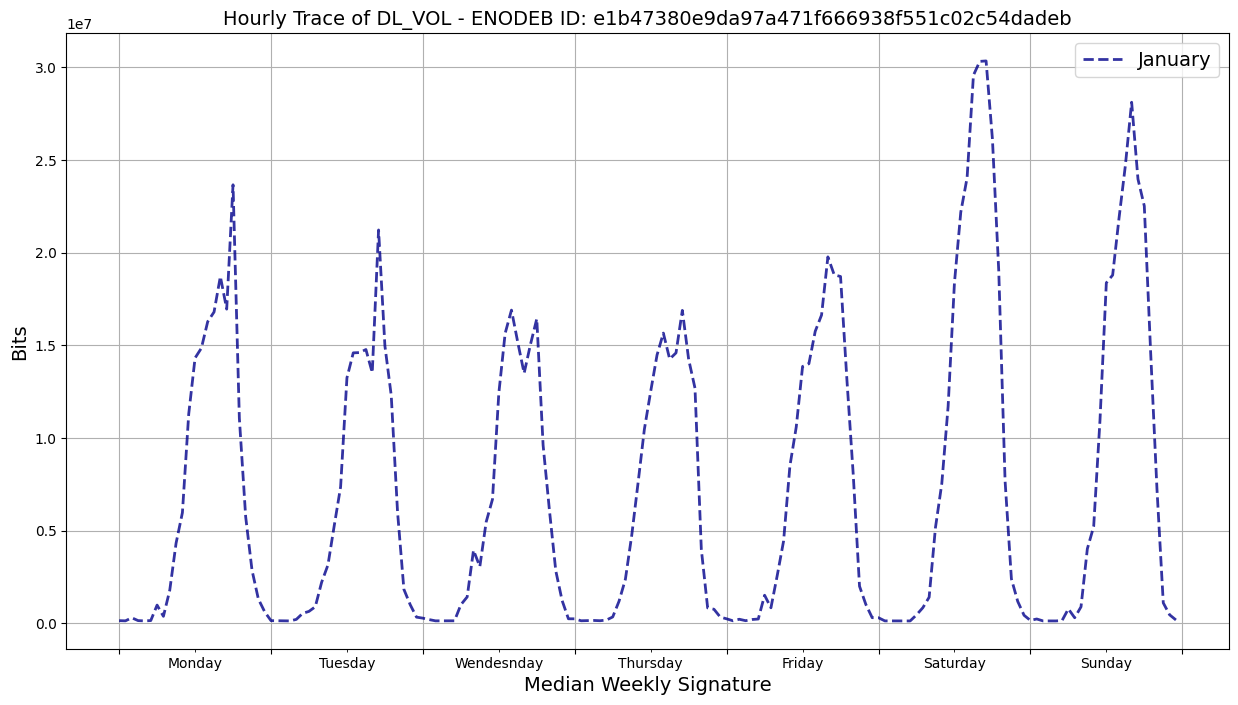

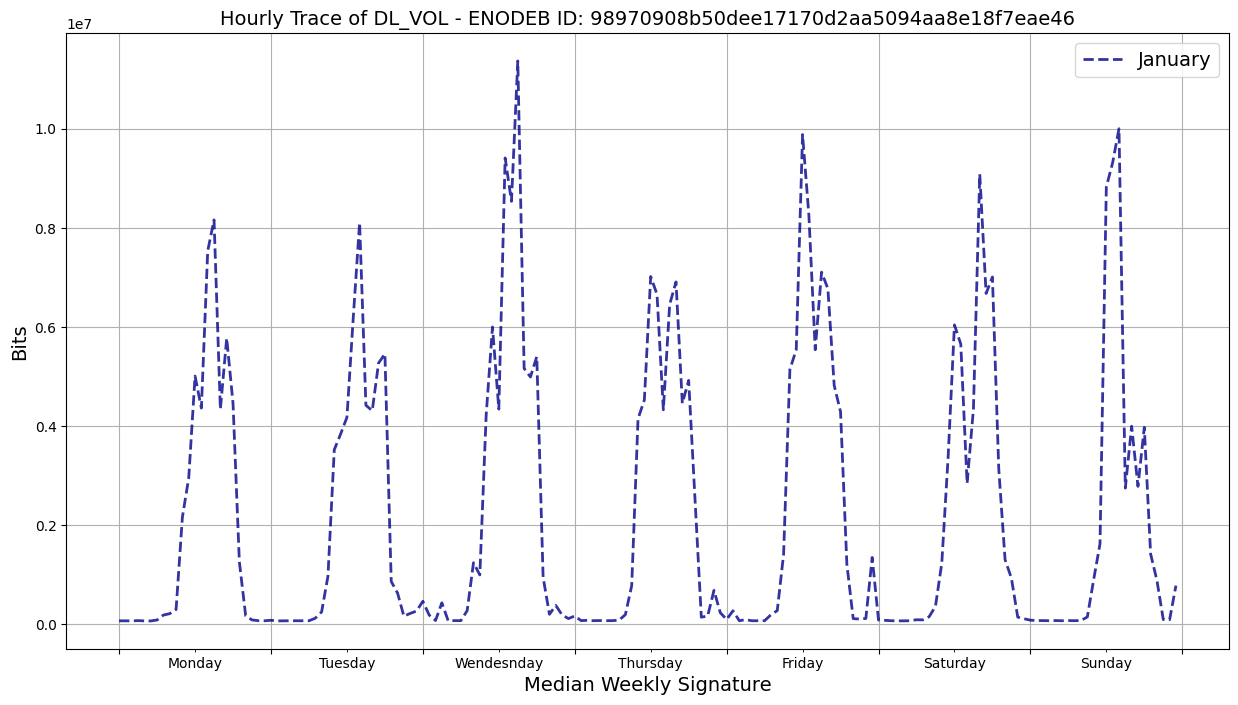

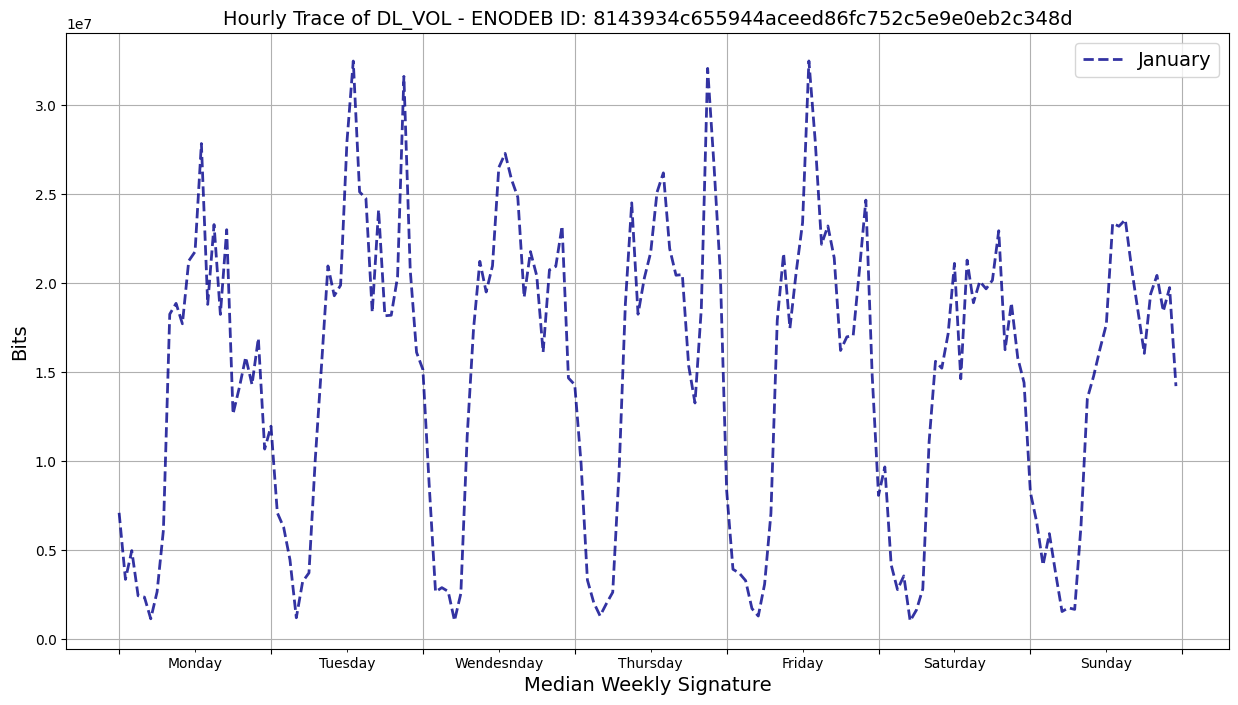

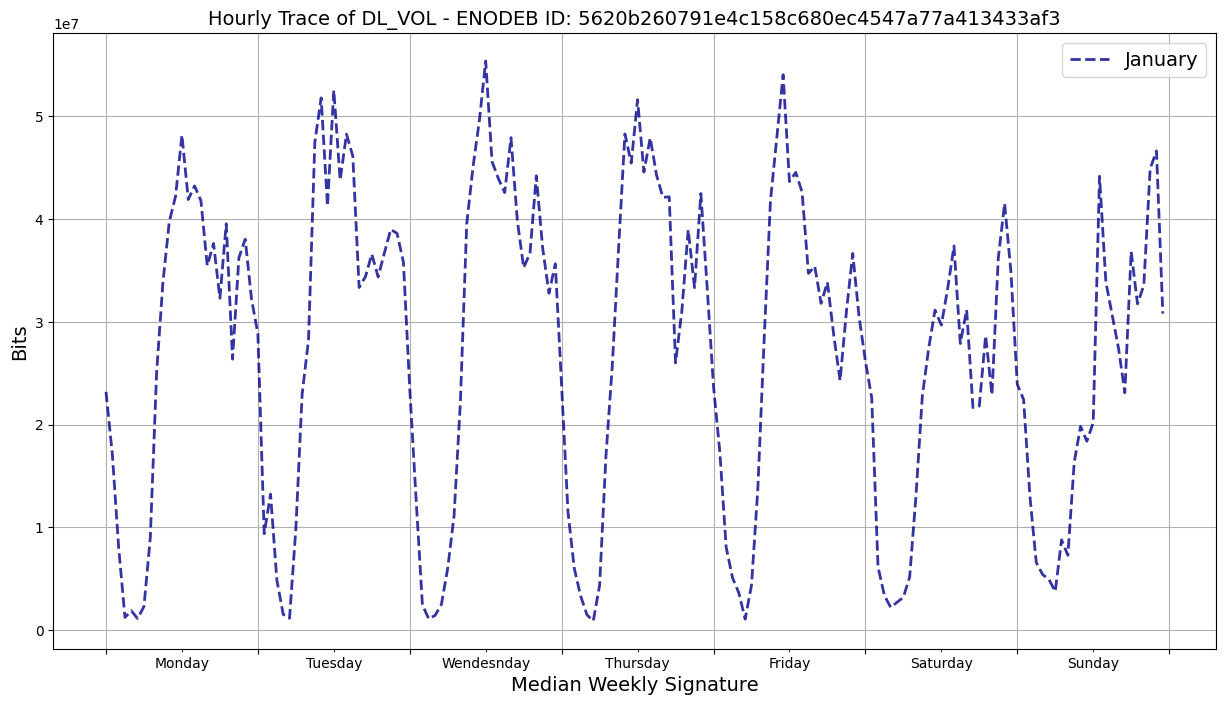

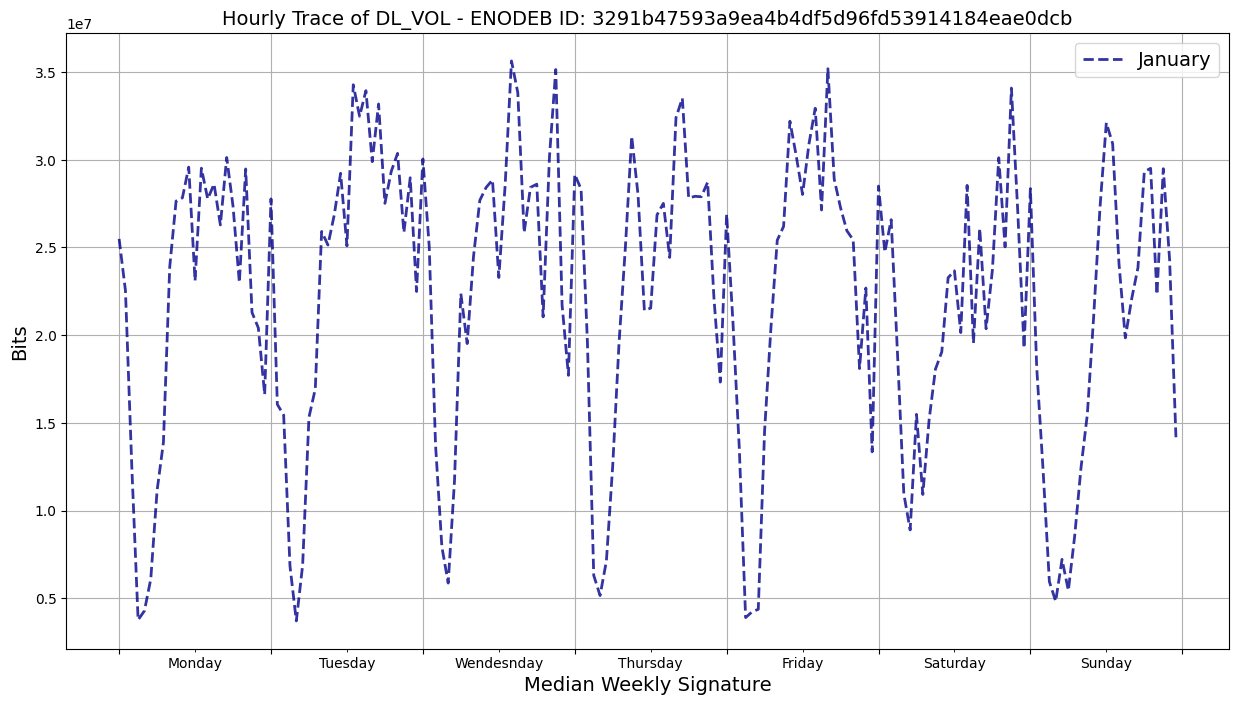

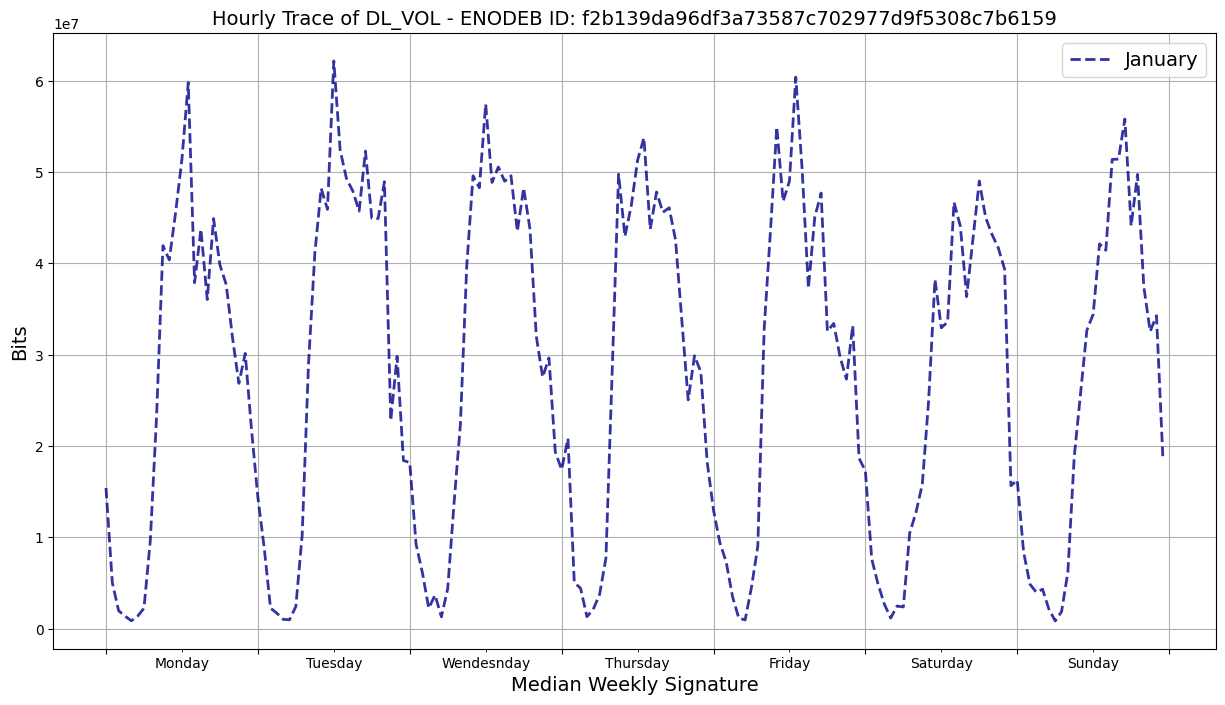

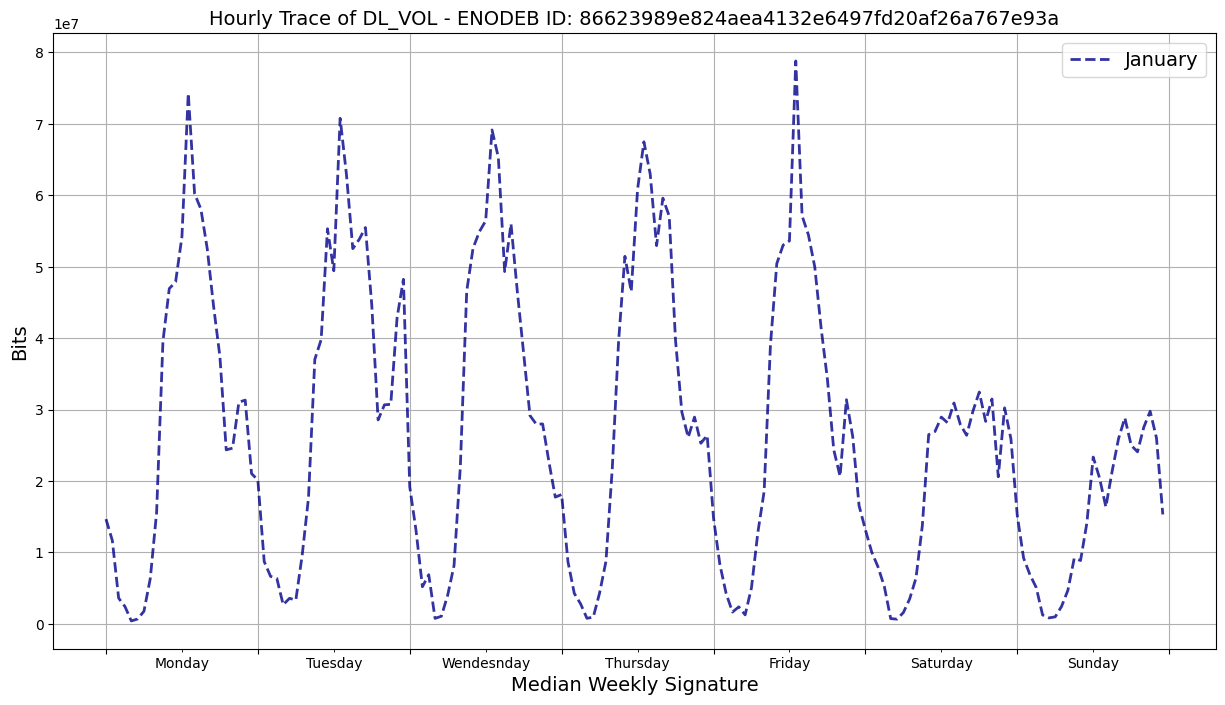

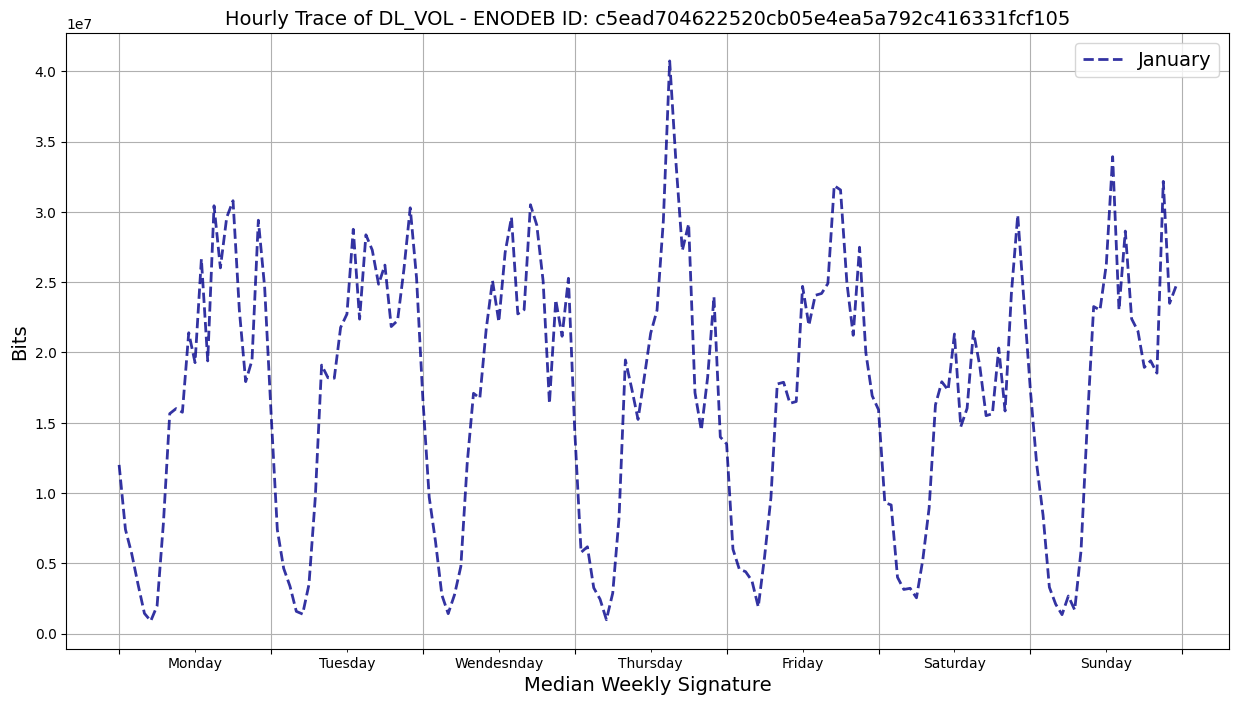

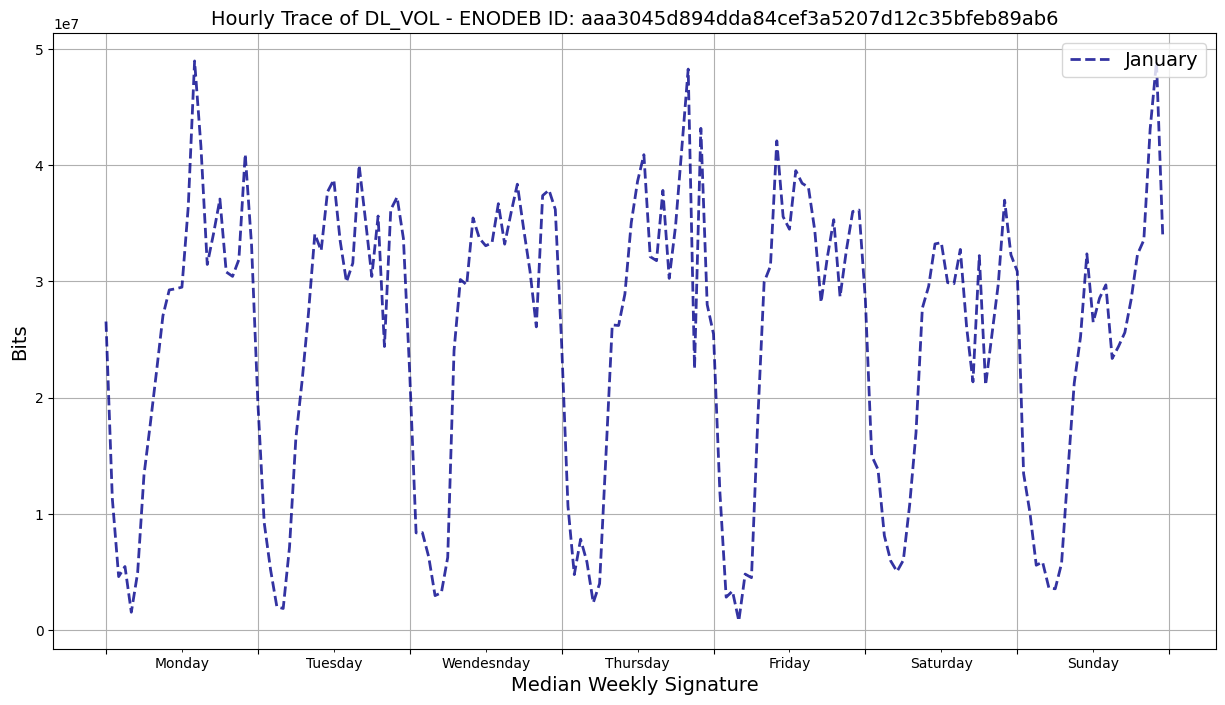

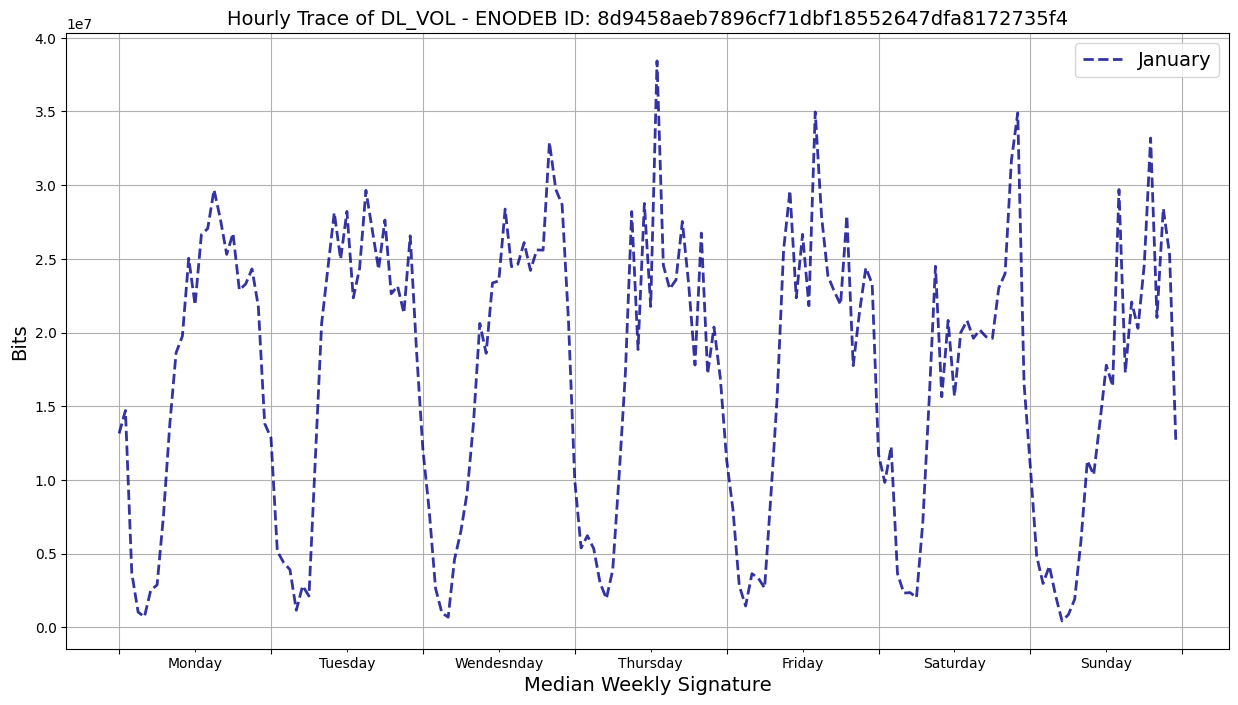

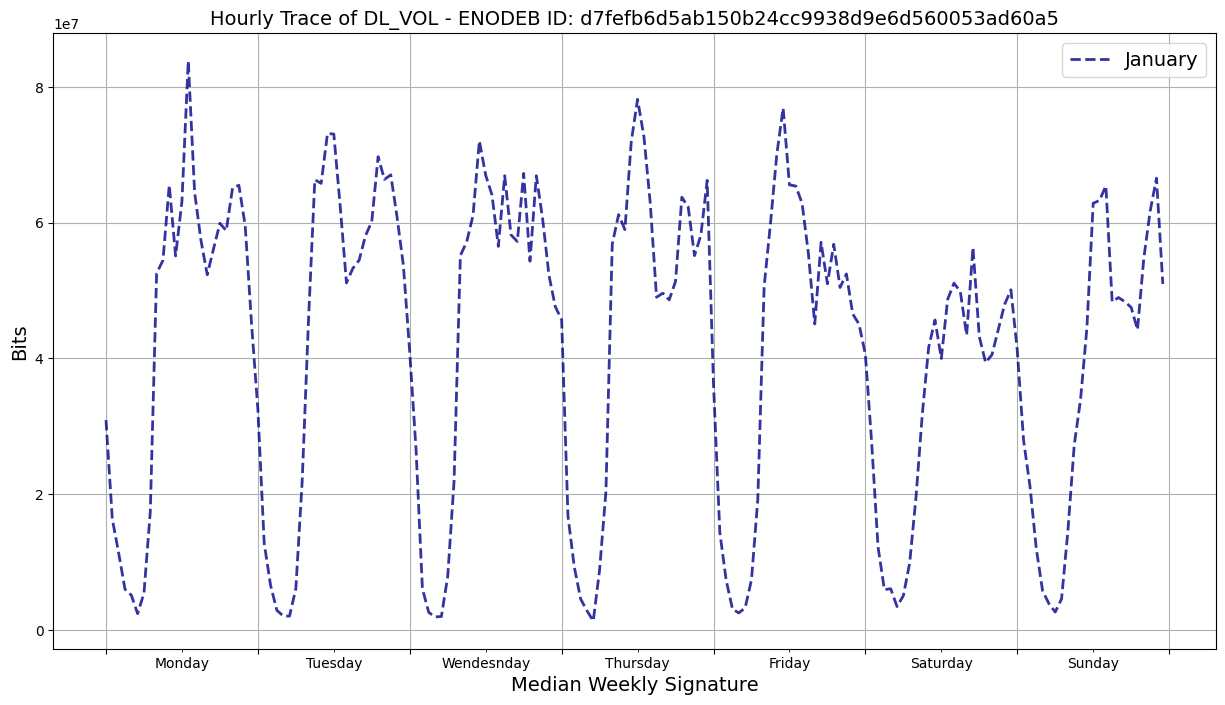

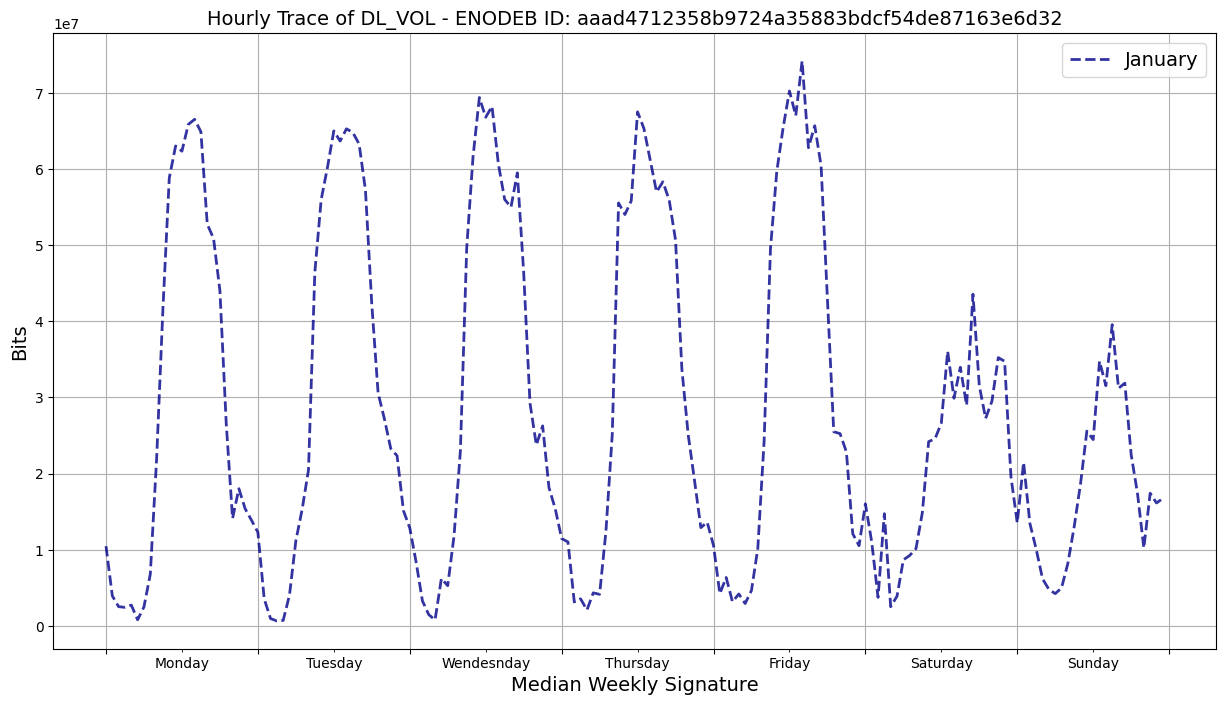

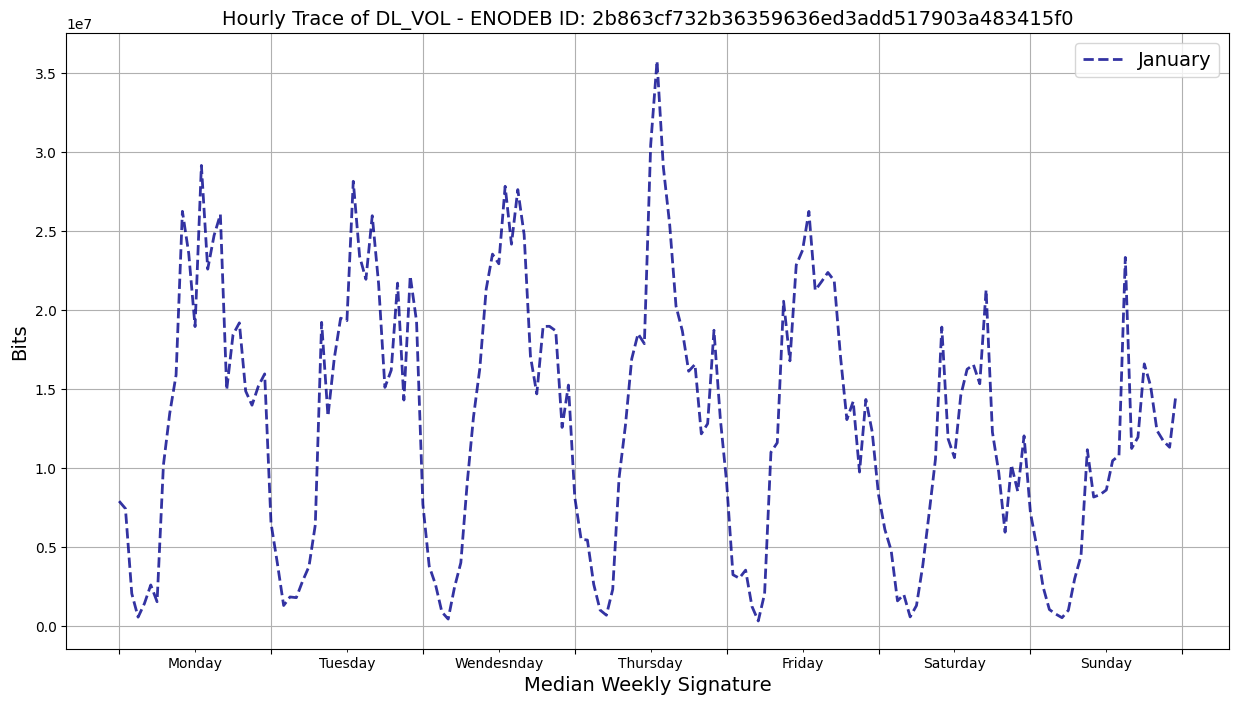

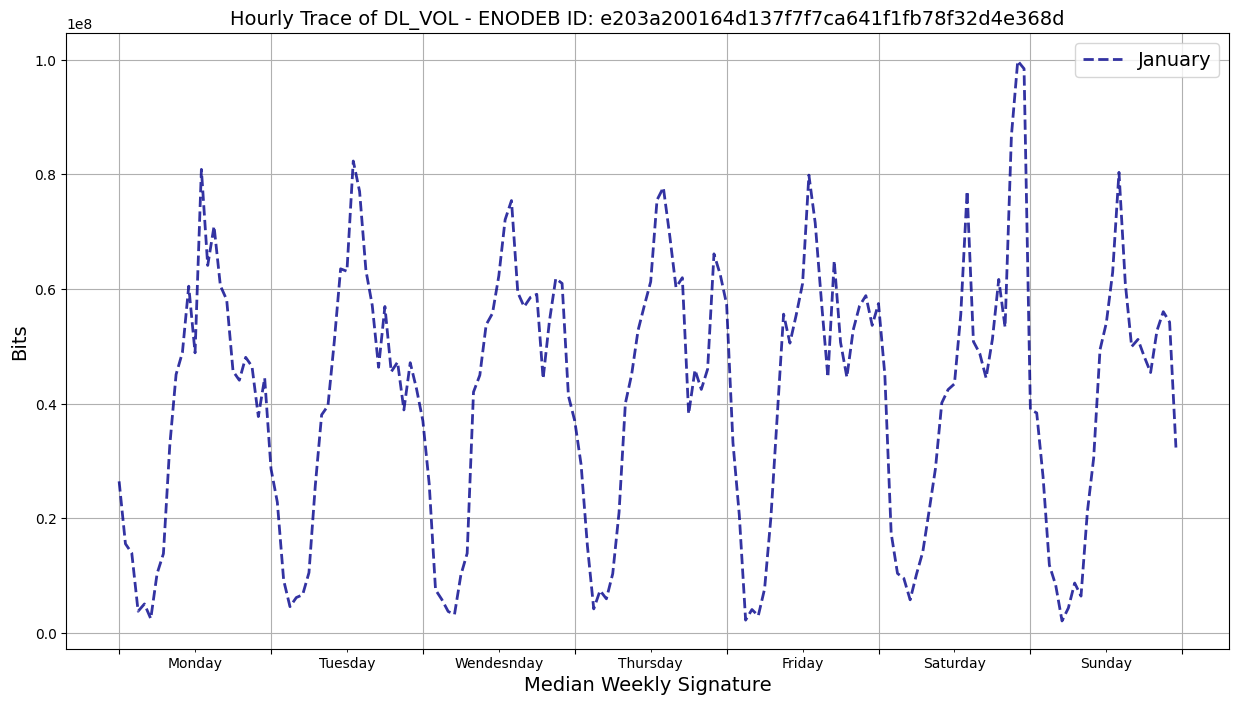

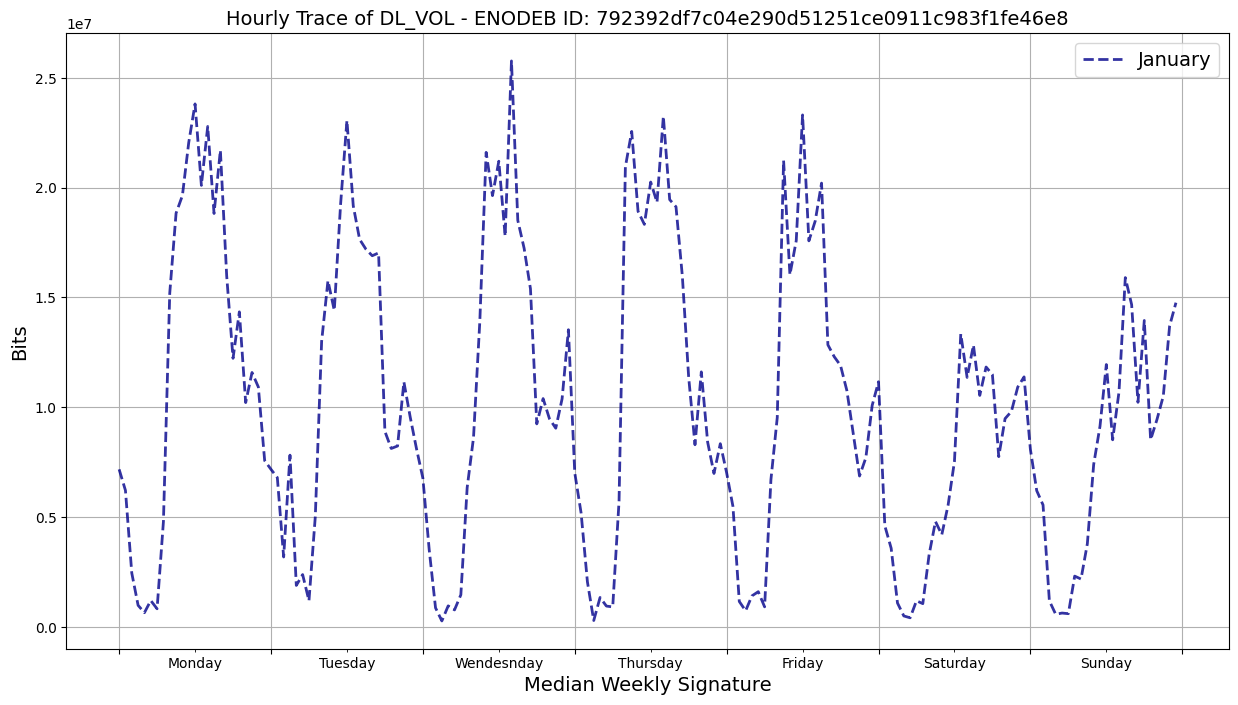

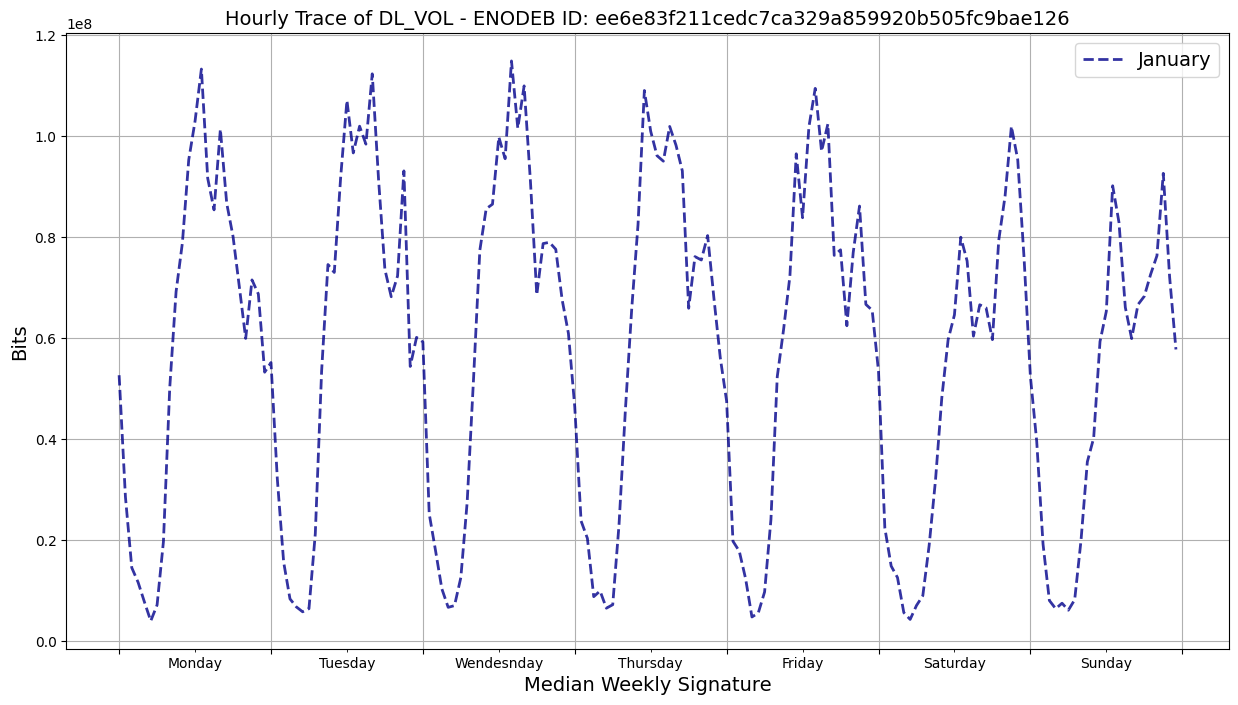

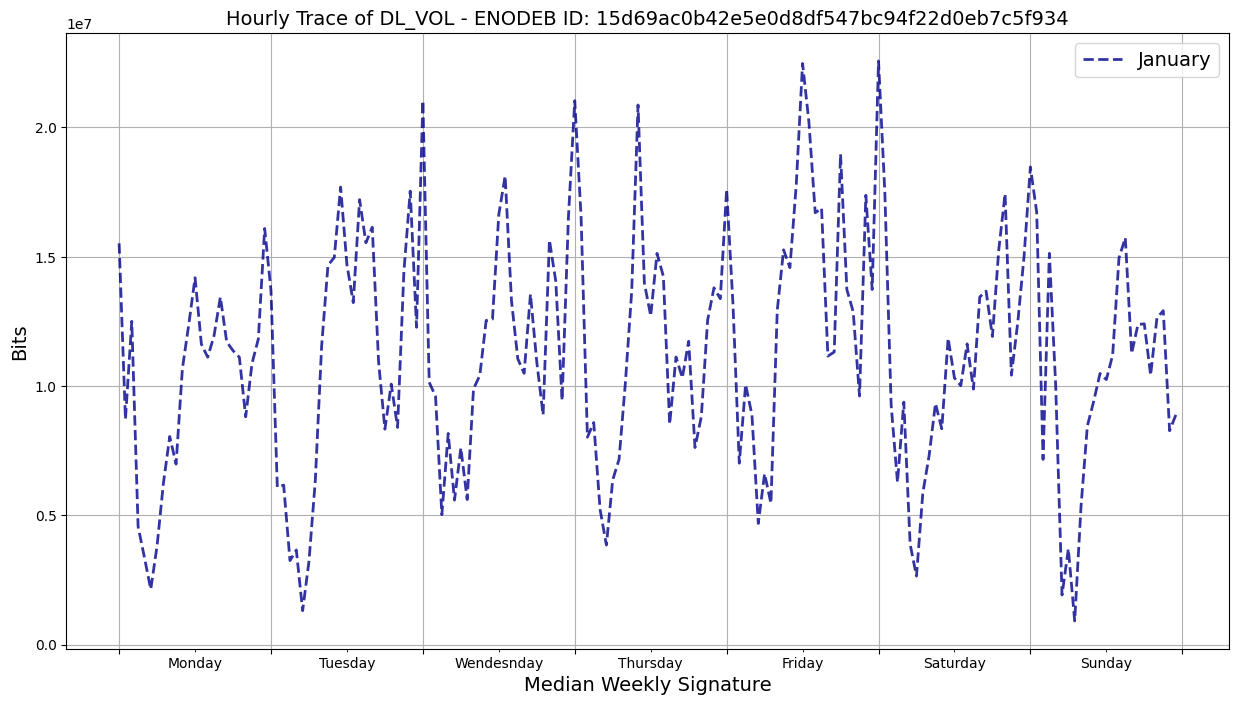

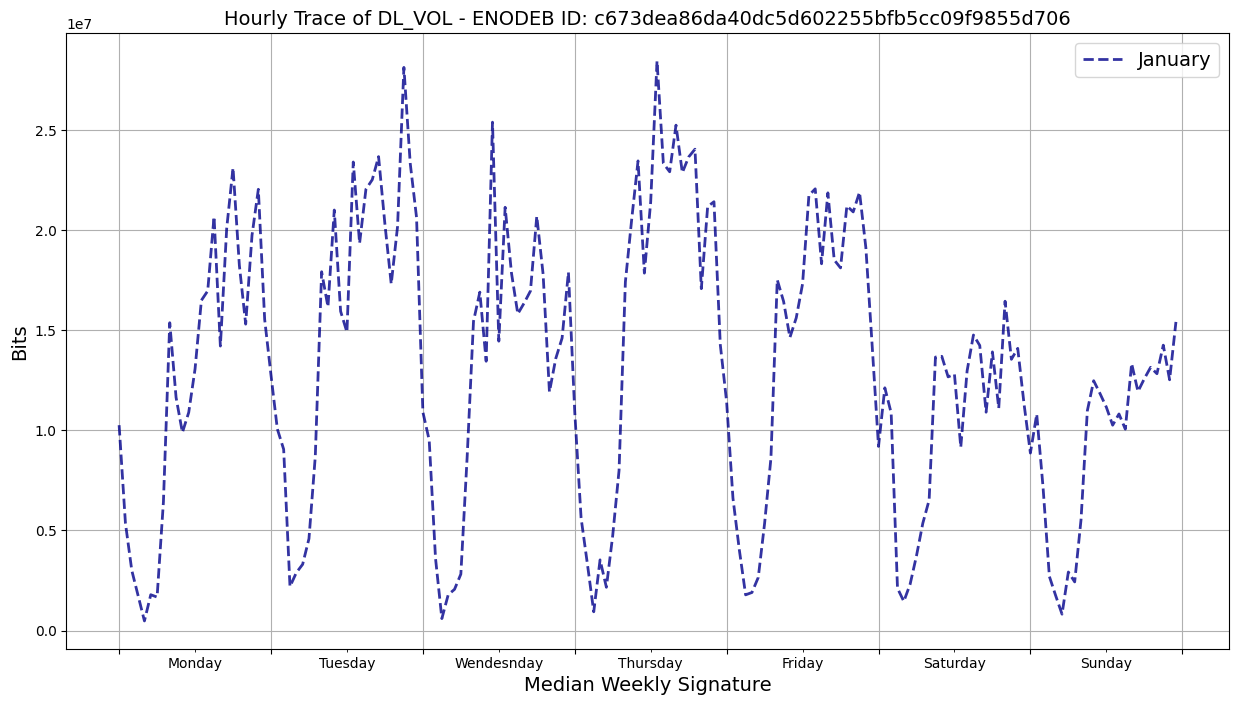

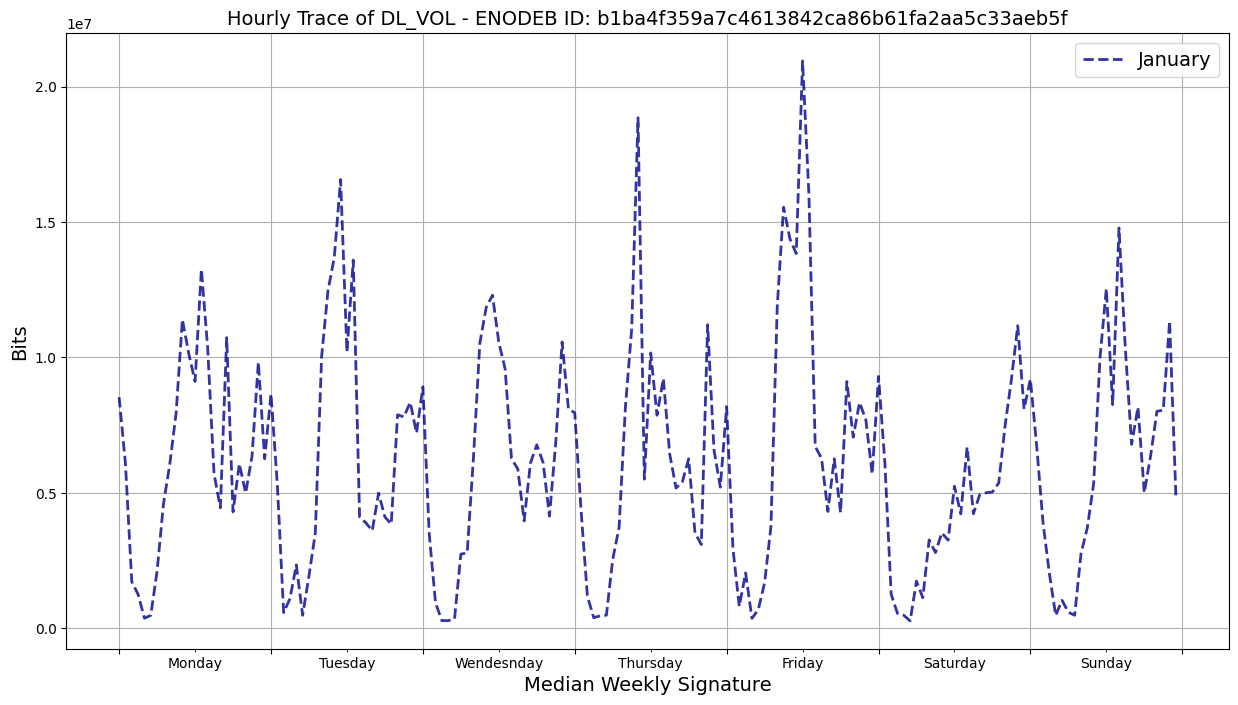

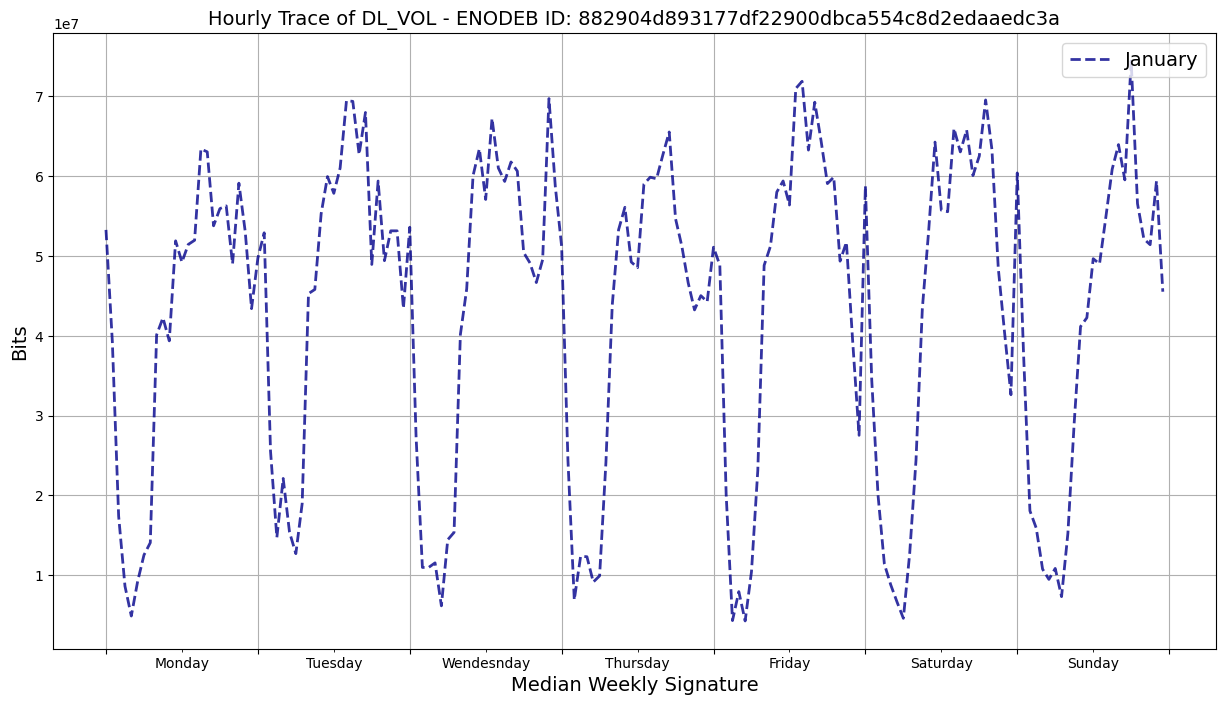

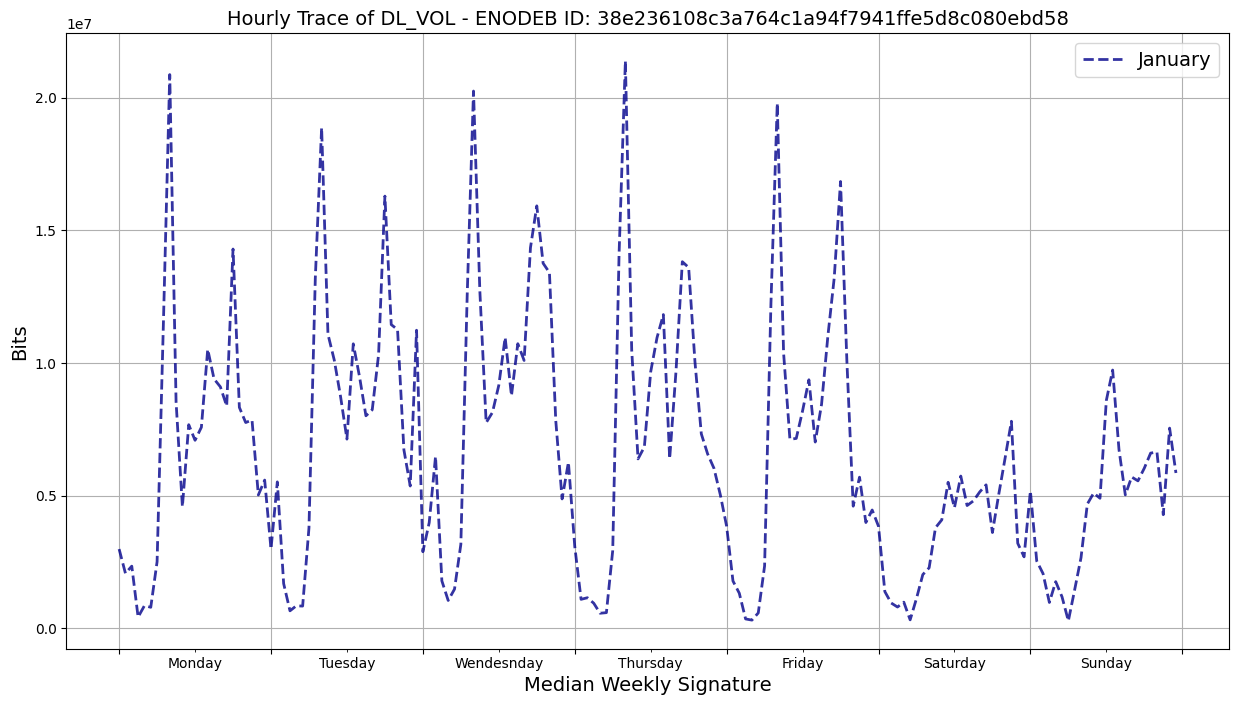

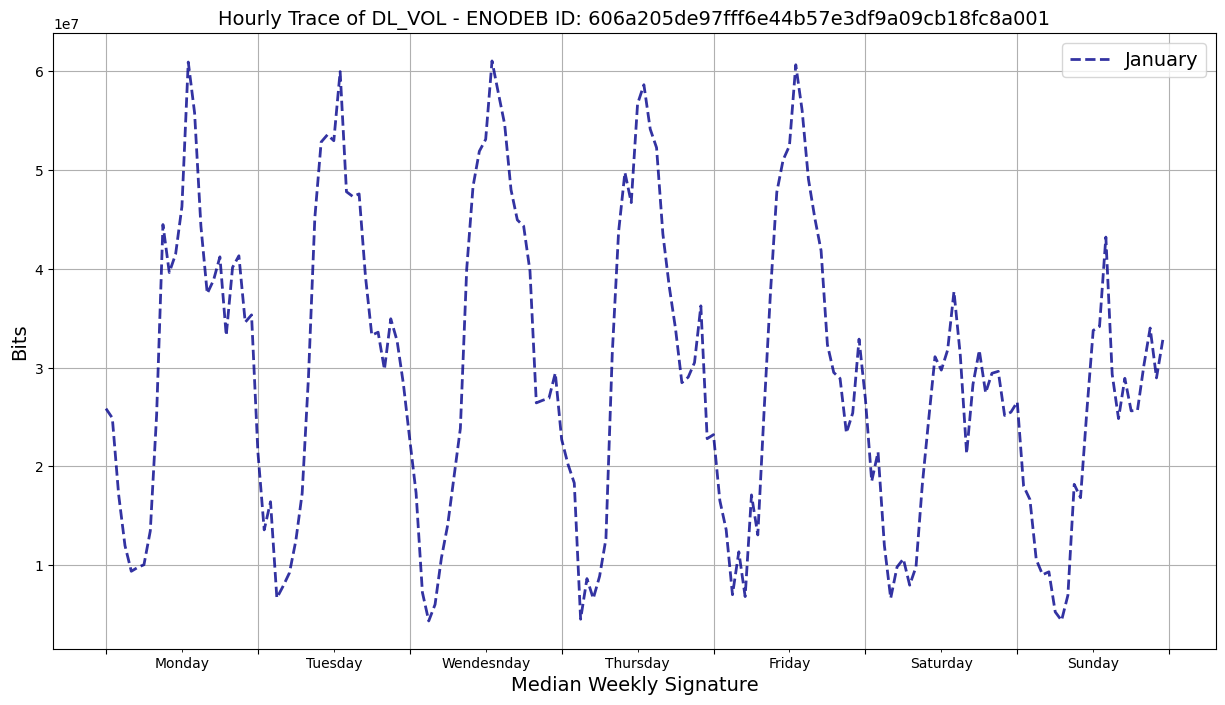

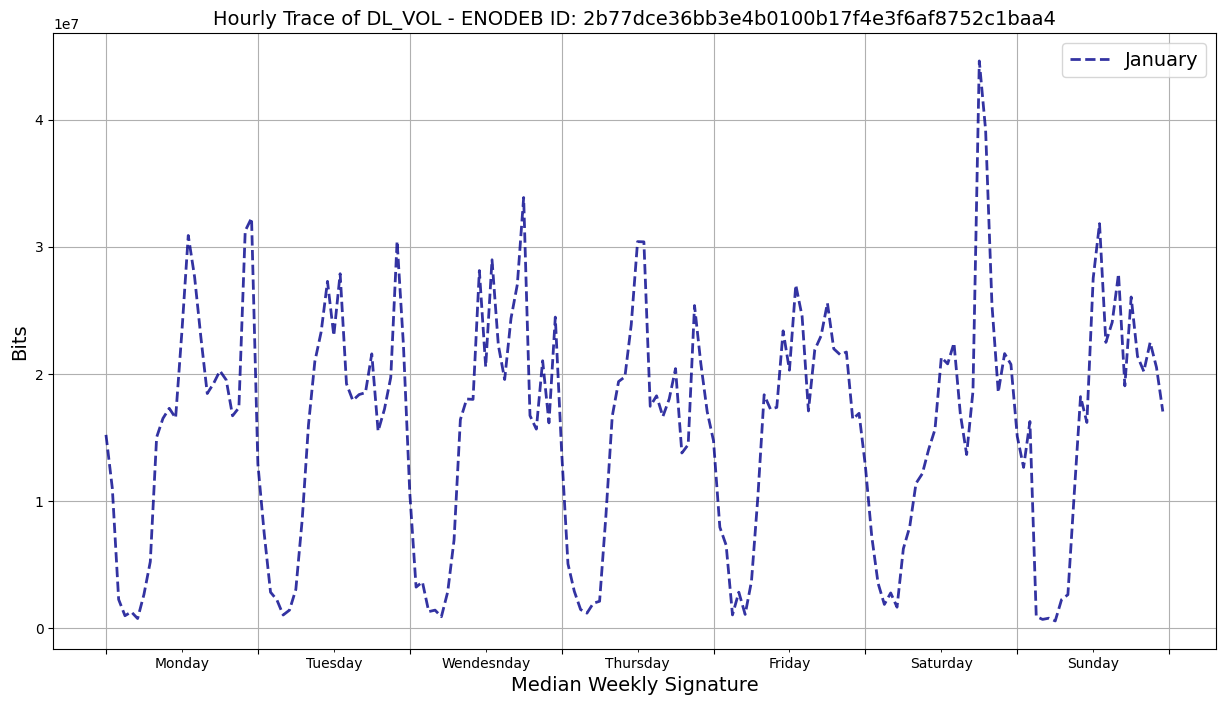

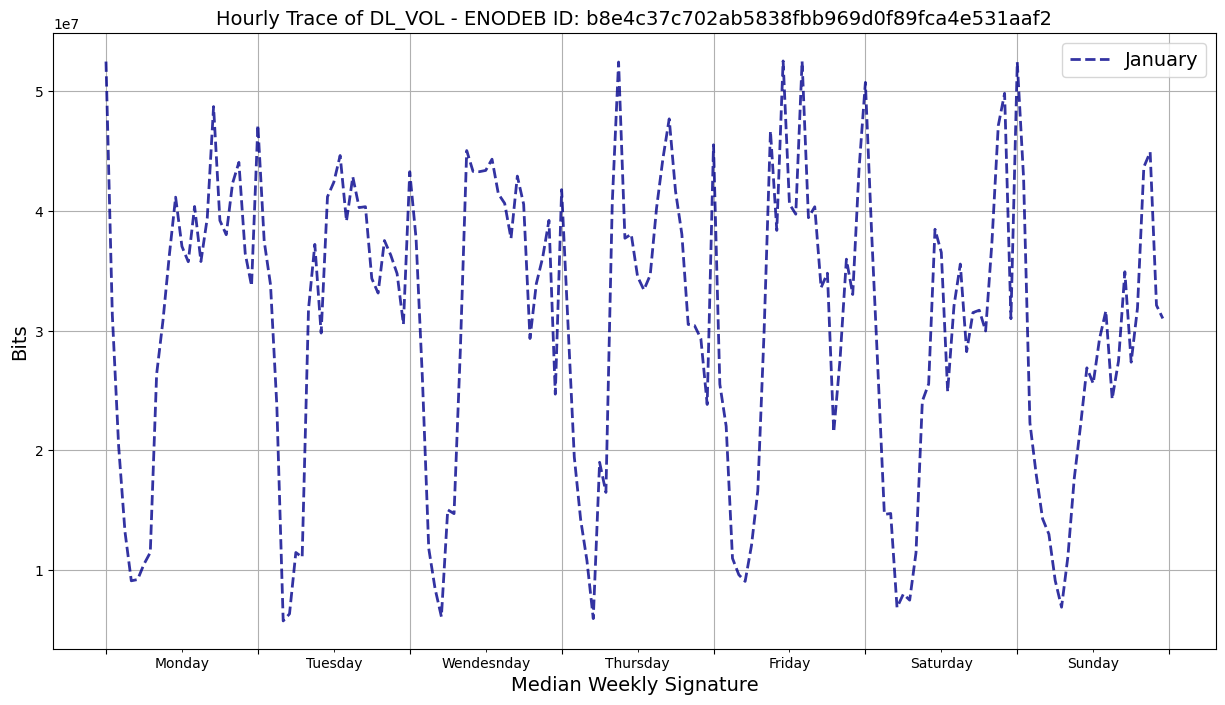

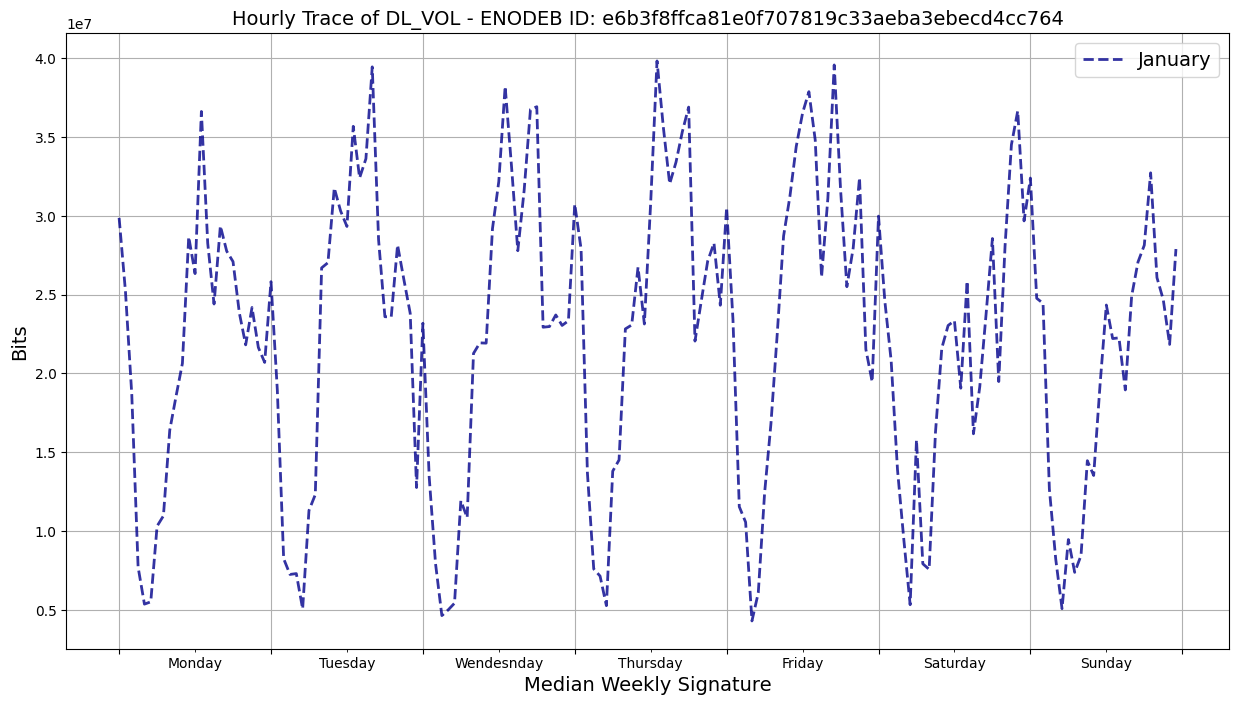

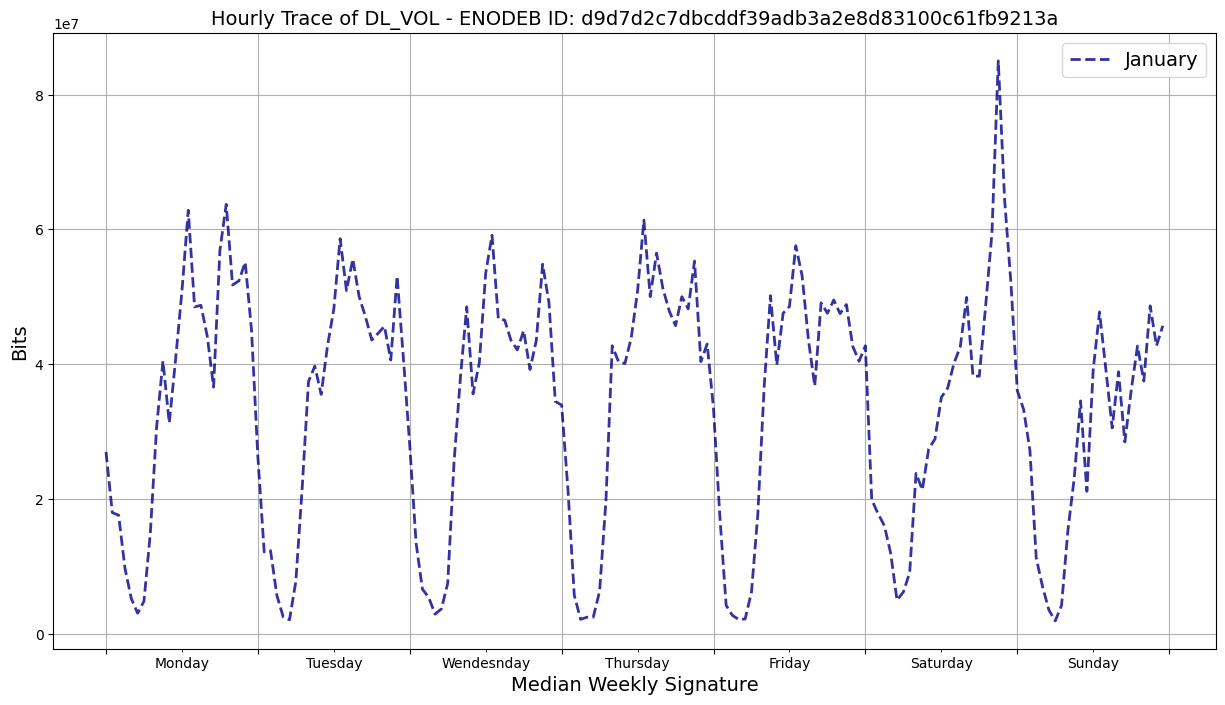

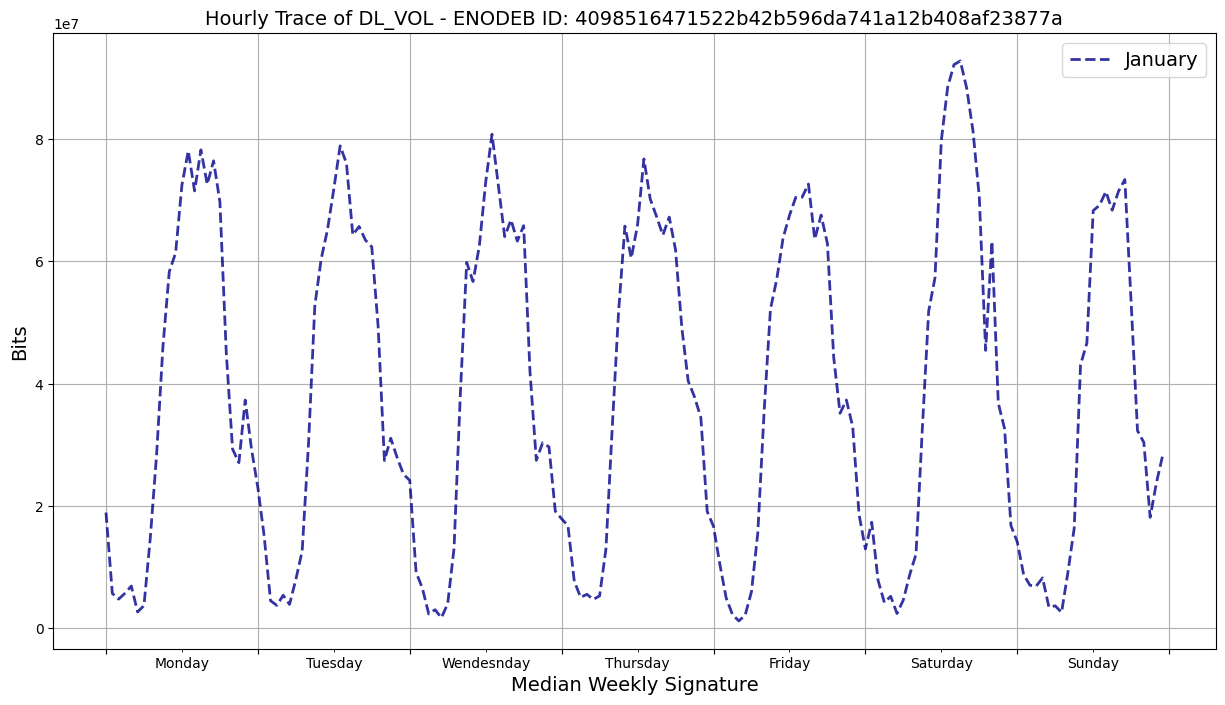

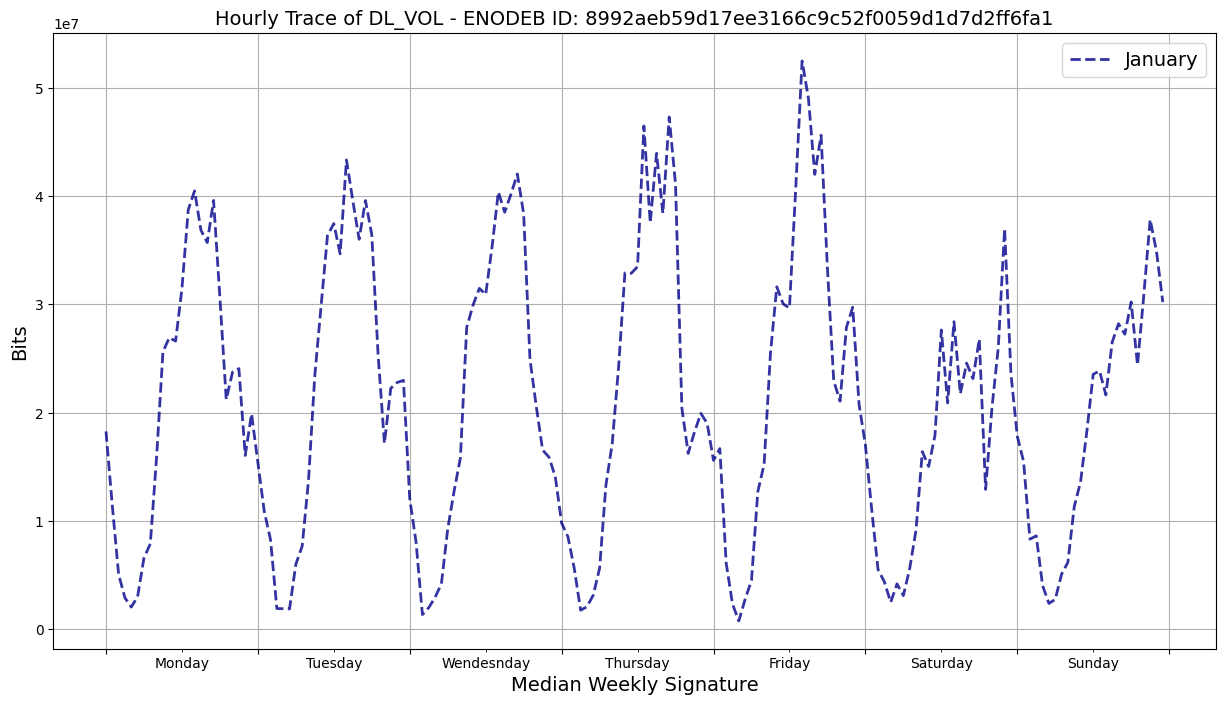

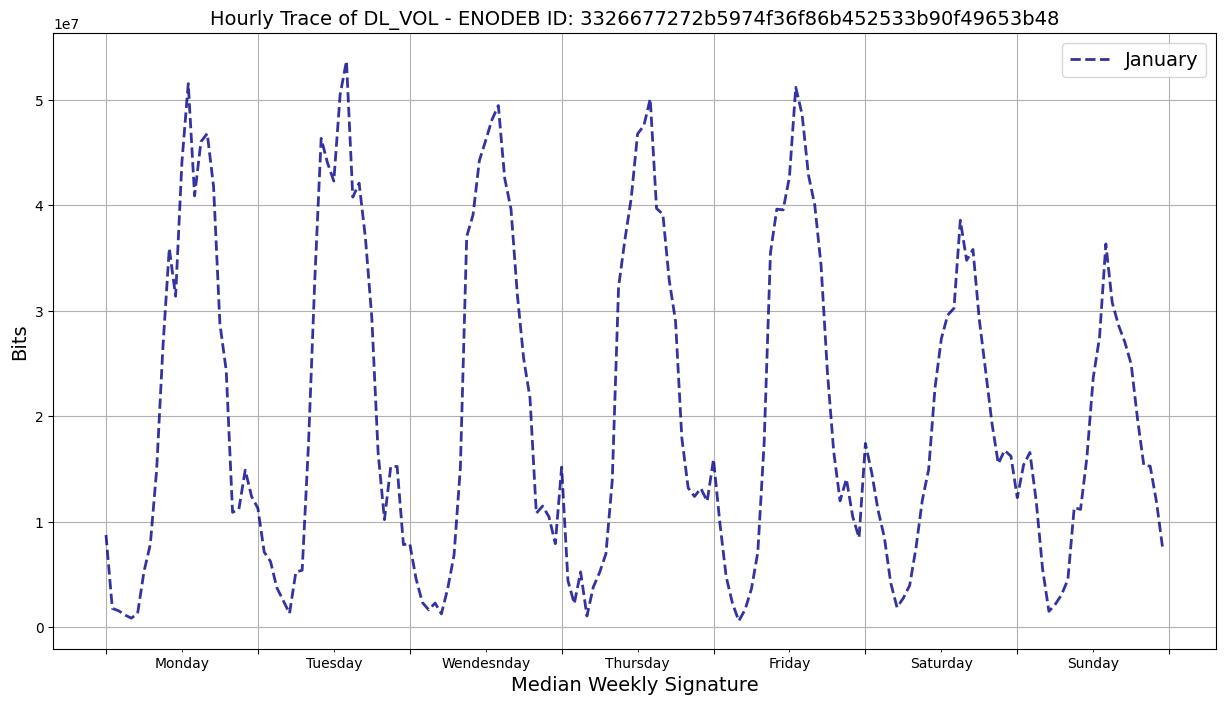

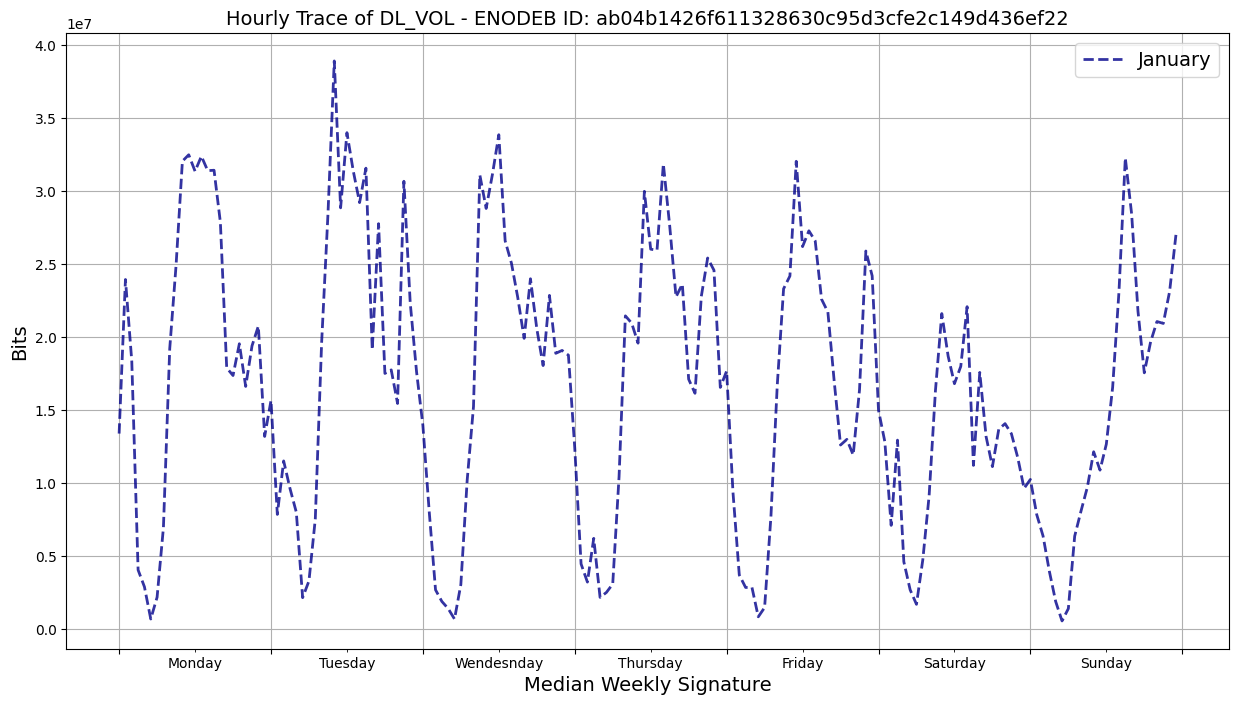

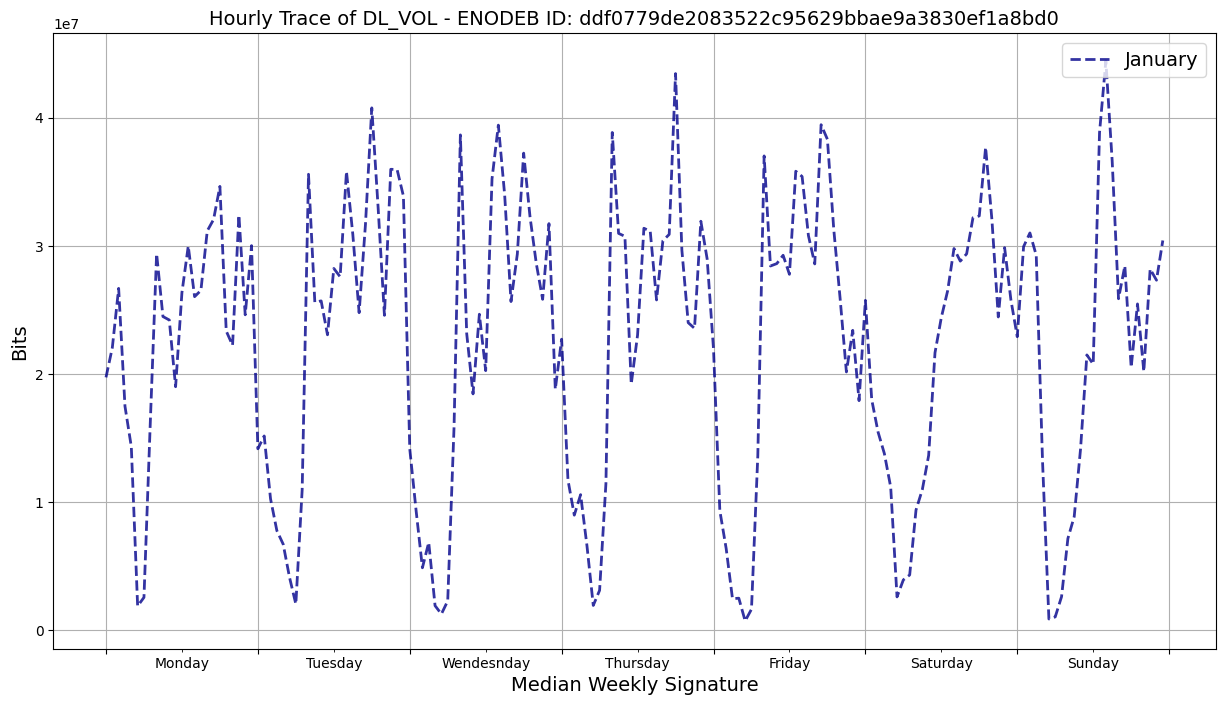

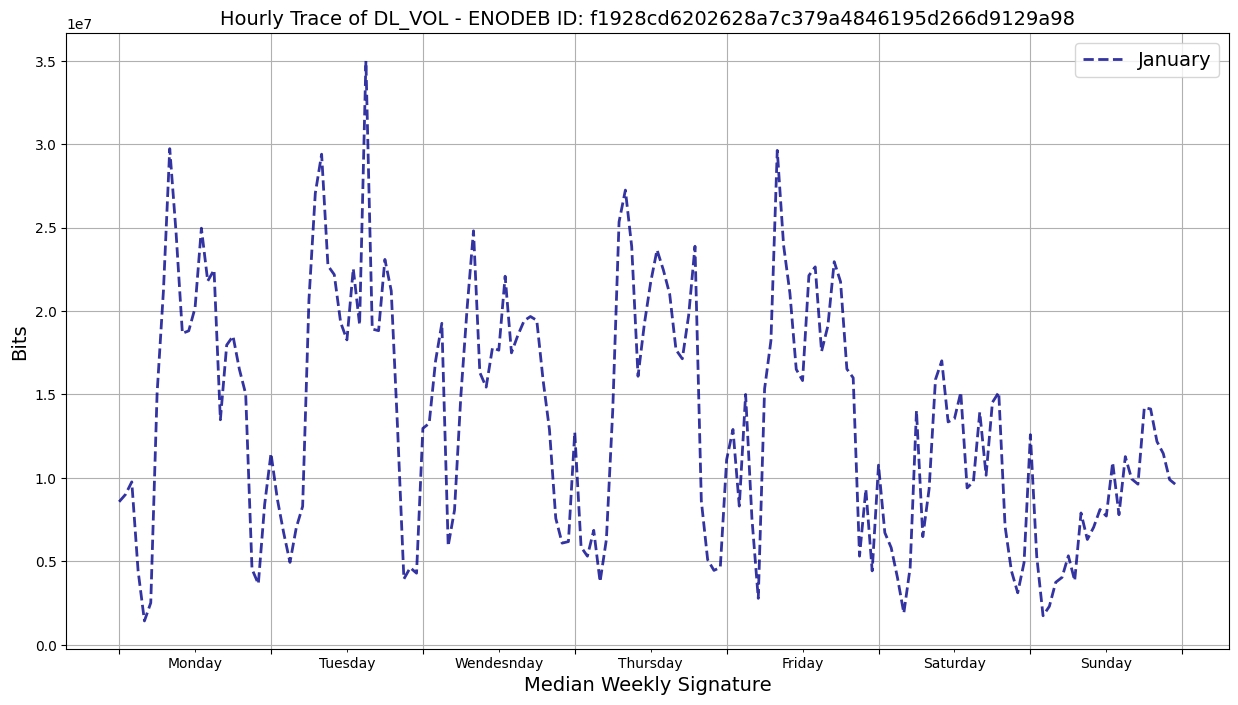

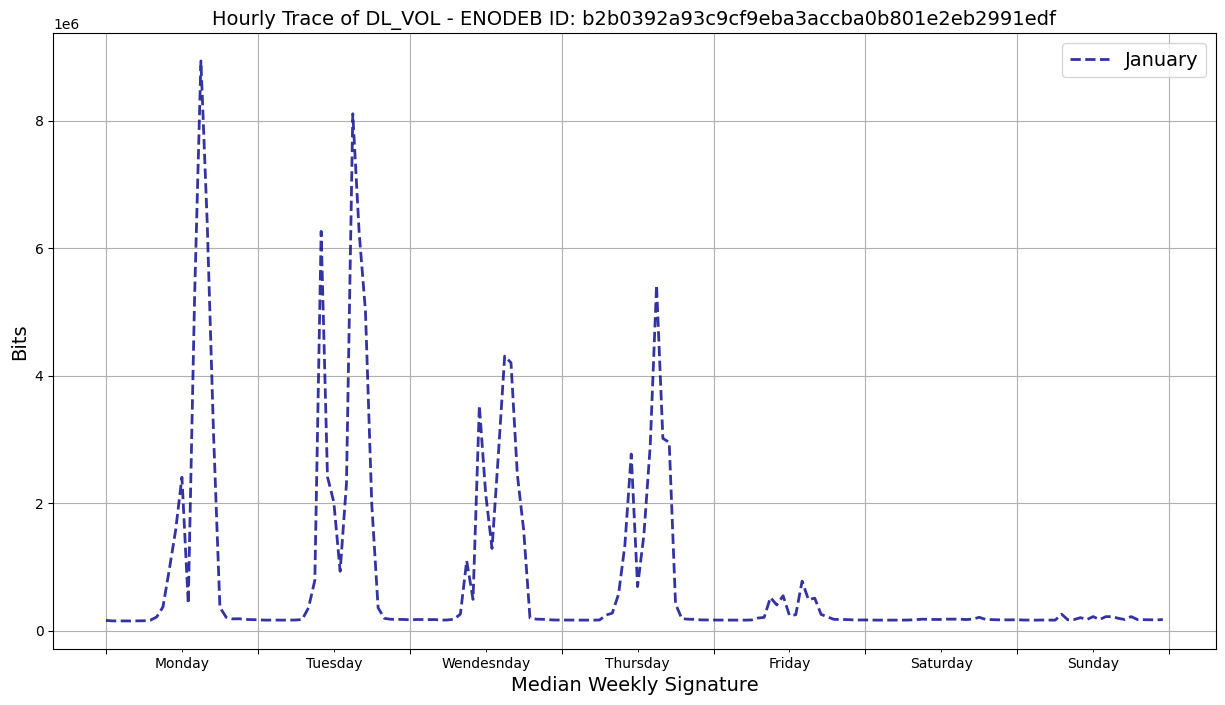

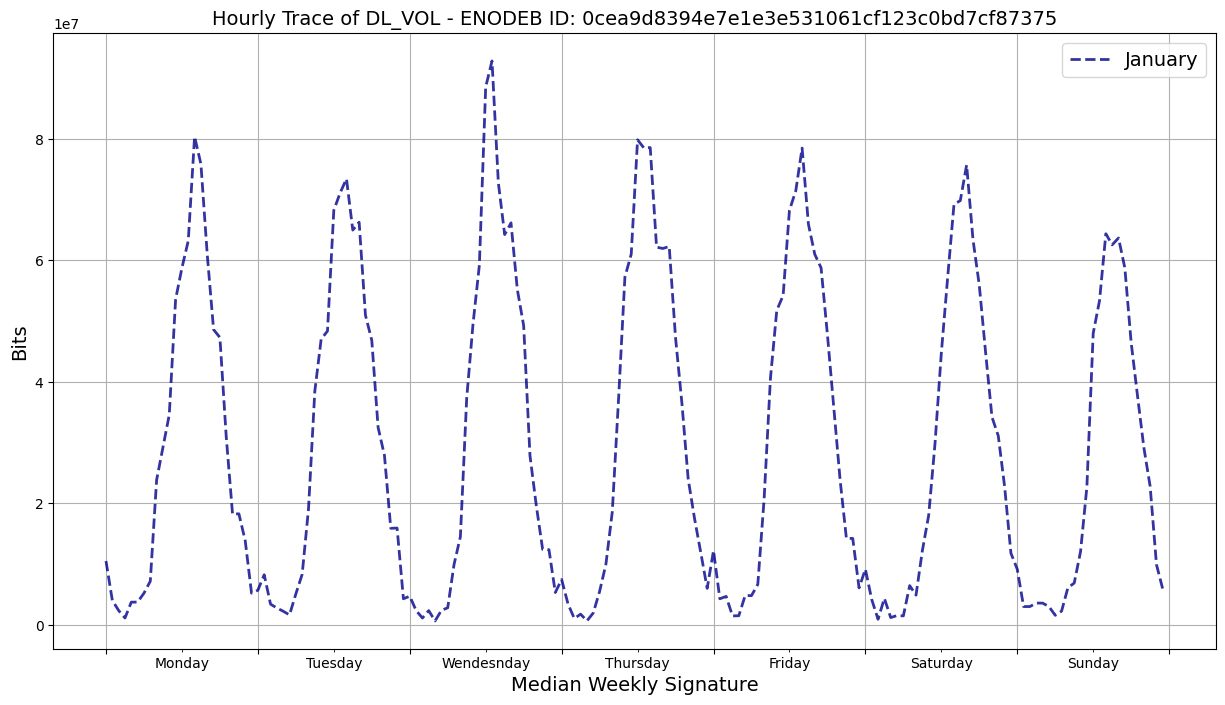

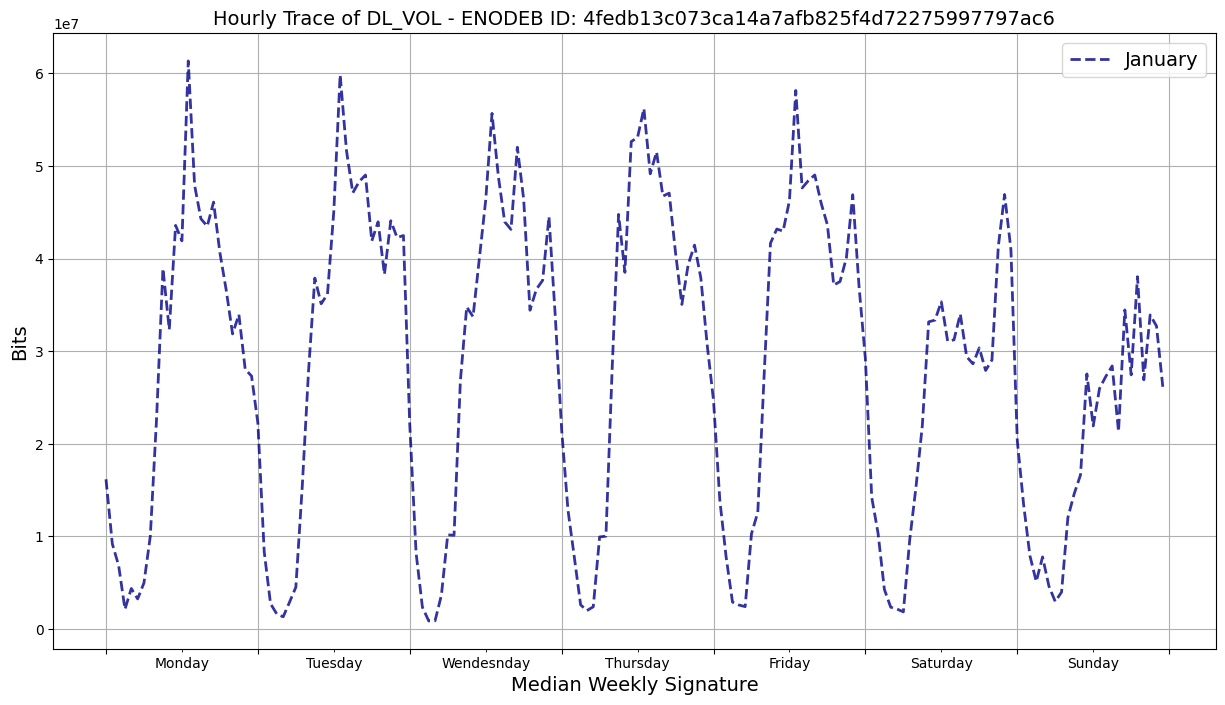

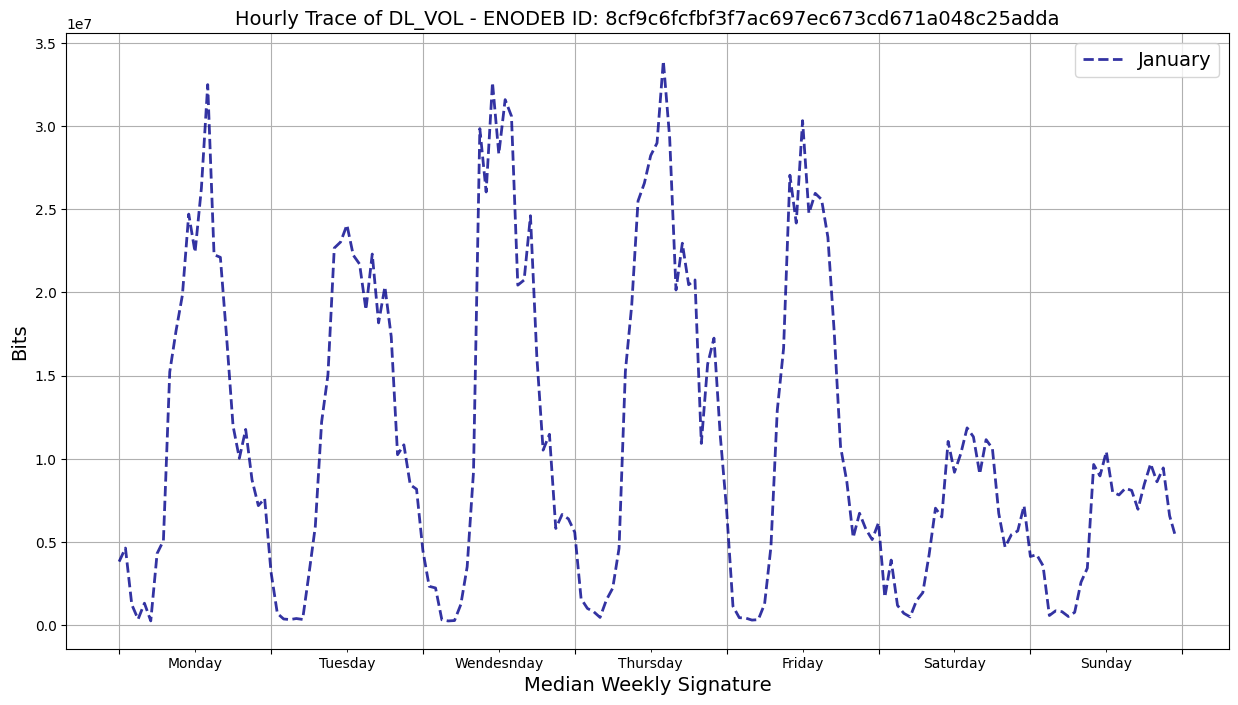

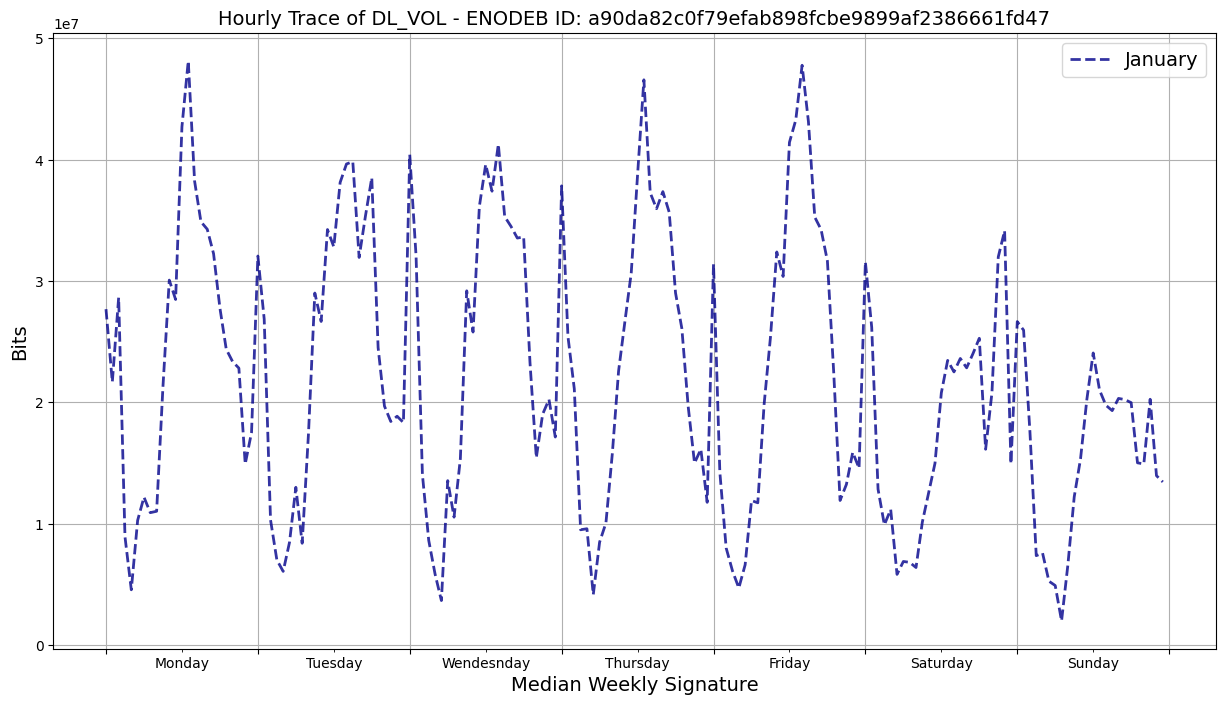

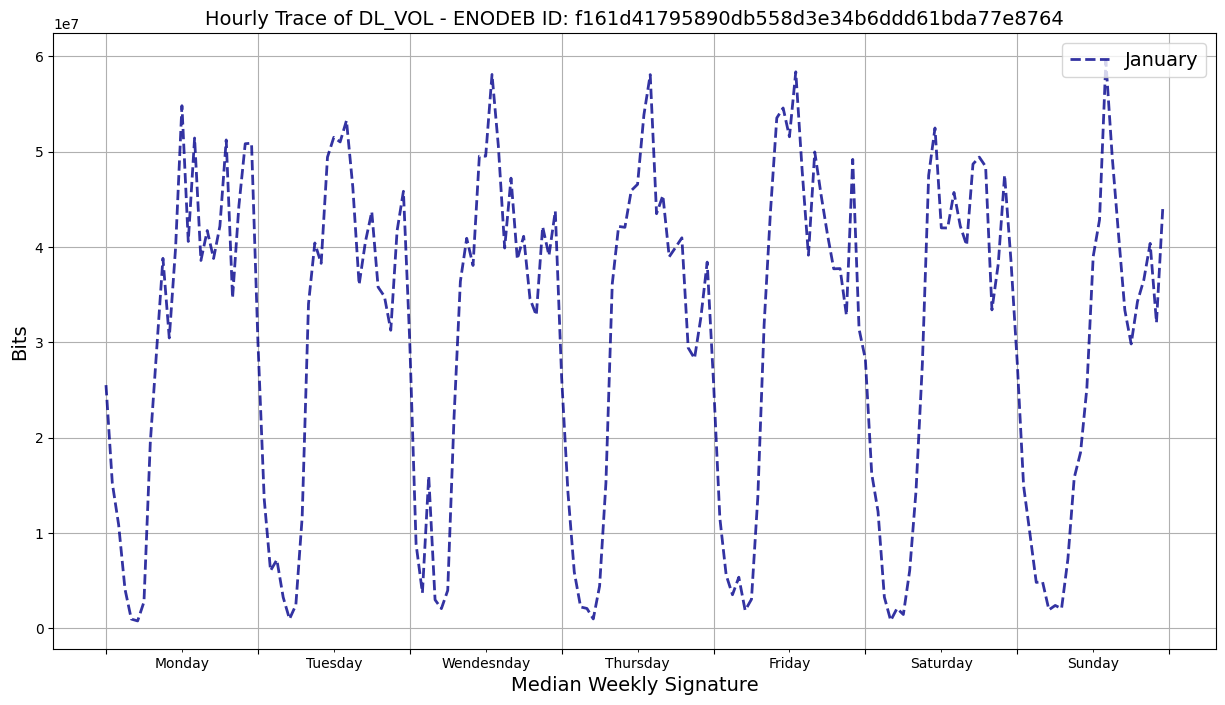

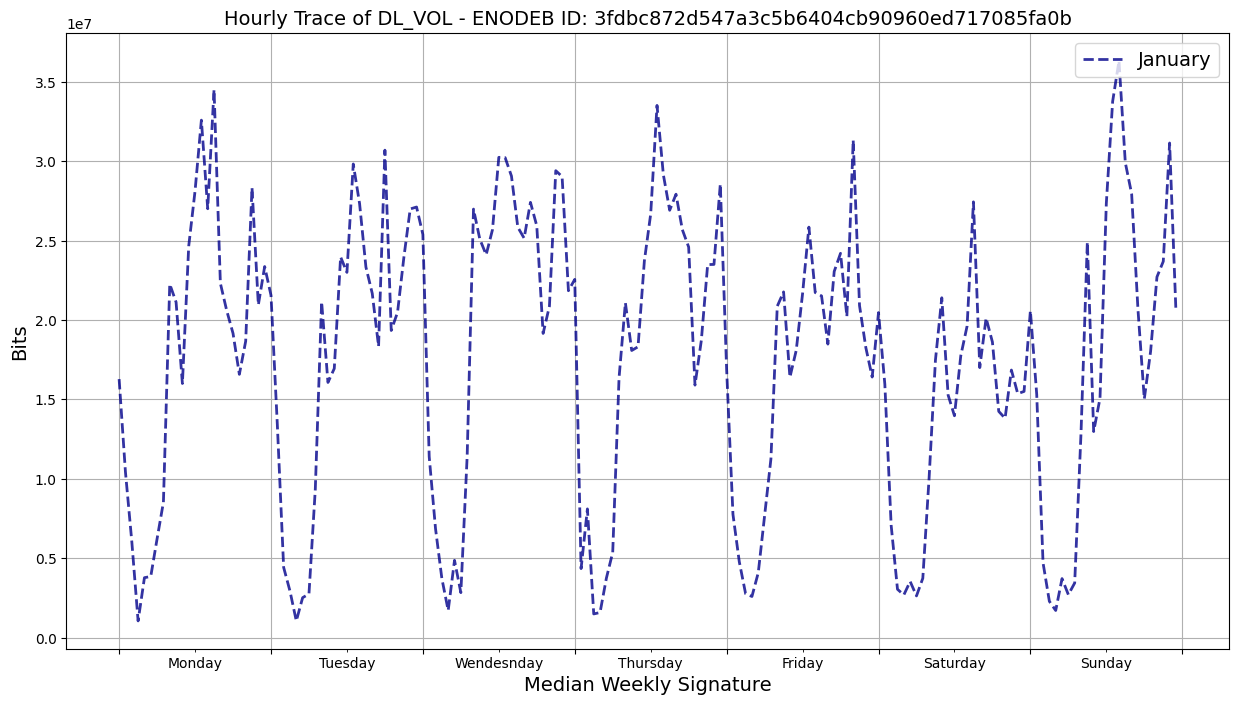

In [342]:
# This section plots the DL Traffic served by cell taken as example in the
# period: Monday 13th - Sunday 20th January 2020 (not the MWS but just the
# traffic observed during the selected week_January)
for i in list_two:    #Put here list_zero, one or two to see each ENODEB median signature for each cluser.

  ref_Jan = pd.DataFrame()
  ref_Feb = pd.DataFrame()
  ref_Mar = pd.DataFrame()
  # Sort hourly samples by date
  for j in statistic_January[i]:
    ref_Jan = pd.concat([ref_Jan,statistic_January[i][j]['Median']],ignore_index=True)

  for j in statistic_February[i]:
    ref_Feb = pd.concat([ref_Feb,statistic_February[i][j]['Median']],ignore_index=True)

  for j in statistic_March[i]:
    ref_Mar = pd.concat([ref_Mar,statistic_March[i][j]['Median']],ignore_index=True)
  # open new figure
  fig, ax = plt.subplots(figsize=(15,8))

  # plot data
  ax.plot(list(range(0,len(ref_Jan))),ref_Jan, linestyle='--', lw=2, color='darkblue', label ='January', alpha=.8)
  #ax.plot(list(range(0,len(ref_Feb))),ref_Feb, linestyle='--', lw=2, color='b', label ='February', alpha=.8)
  #ax.plot(list(range(0,len(ref_Mar))),ref_Mar, linestyle='--', lw=2, color='r', label ='March', alpha=.8)

    # Set plotting options
  days = ['Monday','Tuesday', 'Wendesnday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
  # Set plotting options
  plt.yticks(color='black')
  plt.xticks(color='black', ticks = [0,24,48,72,96,120,144,168])
  ax.xaxis.set_major_formatter(ticker.NullFormatter())
  ax.xaxis.set_minor_locator(ticker.FixedLocator([12, 36, 60, 84, 108, 132, 156]))
  ax.xaxis.set_minor_formatter(ticker.FixedFormatter(days))
  plt.grid(1)
  plt.setp( ax.xaxis.get_majorticklabels(), rotation_mode="anchor")
  plt.xlabel('Median Weekly Signature', color='black', fontsize=14)
  plt.ylabel('Bits', color='black', fontsize=14) # unit of measure depends on the considered KPI
  plt.legend(loc="upper right", fontsize = 14)
  plt.title('Hourly Trace of '+'DL_VOL'+' - ENODEB ID: %s'%i, fontsize=14)
  plt.show()

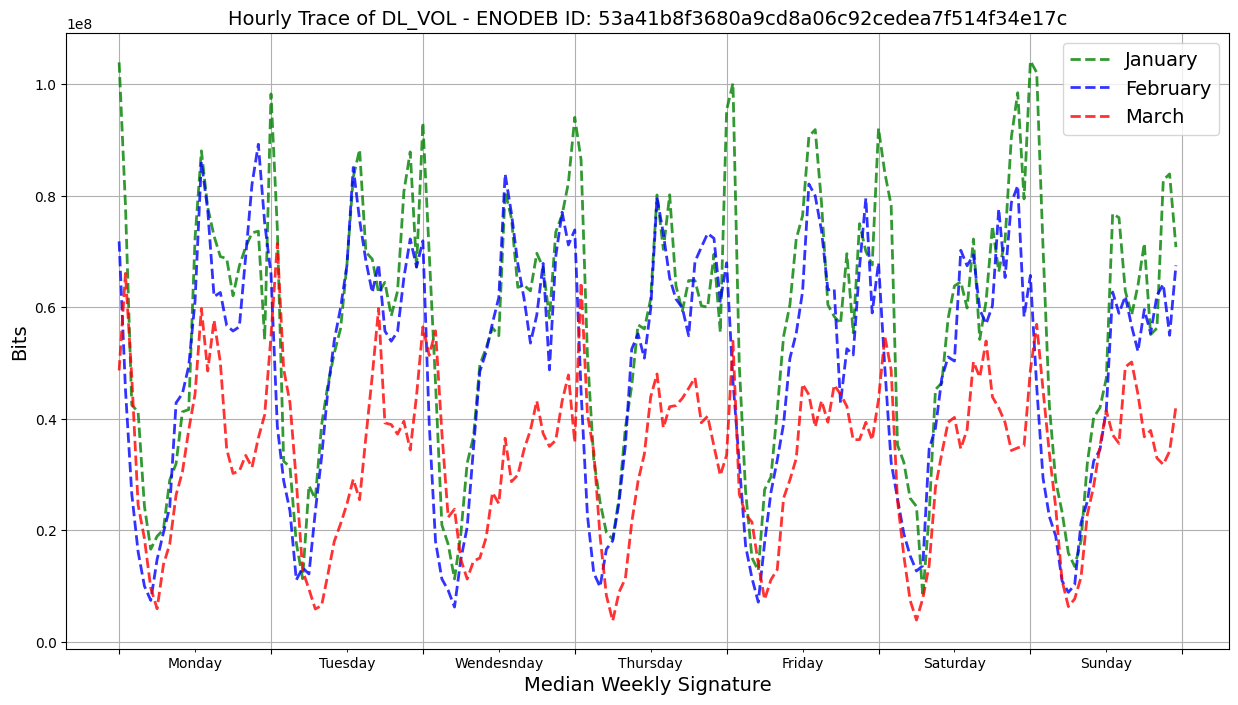

In [286]:
#We chose this enodeB for transport: the peaks can be clearly seen around the morning and the evening

enodeb_id = '53a41b8f3680a9cd8a06c92cedea7f514f34e17c'
ref_Jan = pd.DataFrame()
ref_Feb = pd.DataFrame()
ref_Mar = pd.DataFrame()
# Sort hourly samples by date
for j in statistic_January[i]:
  ref_Jan = pd.concat([ref_Jan,statistic_January[enodeb_id][j]['Median']],ignore_index=True)

for j in statistic_February[i]:
  ref_Feb = pd.concat([ref_Feb,statistic_February[enodeb_id][j]['Median']],ignore_index=True)

for j in statistic_March[i]:
  ref_Mar = pd.concat([ref_Mar,statistic_March[enodeb_id][j]['Median']],ignore_index=True)
# open new figure
fig, ax = plt.subplots(figsize=(15,8))

# plot data
ax.plot(list(range(0,len(ref_Jan))),ref_Jan, linestyle='--', lw=2, color='g', label ='January', alpha=.8)
ax.plot(list(range(0,len(ref_Feb))),ref_Feb, linestyle='--', lw=2, color='b', label ='February', alpha=.8)
ax.plot(list(range(0,len(ref_Mar))),ref_Mar, linestyle='--', lw=2, color='r', label ='March', alpha=.8)

days = ['Monday','Tuesday', 'Wendesnday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Set plotting options
plt.yticks(color='black')
plt.xticks(color='black', ticks = [0,24,48,72,96,120,144,168])
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_locator(ticker.FixedLocator([12, 36, 60, 84, 108, 132, 156]))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(days))
plt.grid(1)
plt.setp( ax.xaxis.get_majorticklabels(), rotation_mode="anchor")
plt.xlabel('Median Weekly Signature', color='black', fontsize=14)
plt.ylabel('Bits', color='black', fontsize=14) # unit of measure depends on the considered KPI
plt.legend(loc="upper right", fontsize = 14)
plt.title('Hourly Trace of '+'DL_VOL'+' - ENODEB ID: %s'%enodeb_id, fontsize=14)
plt.show()

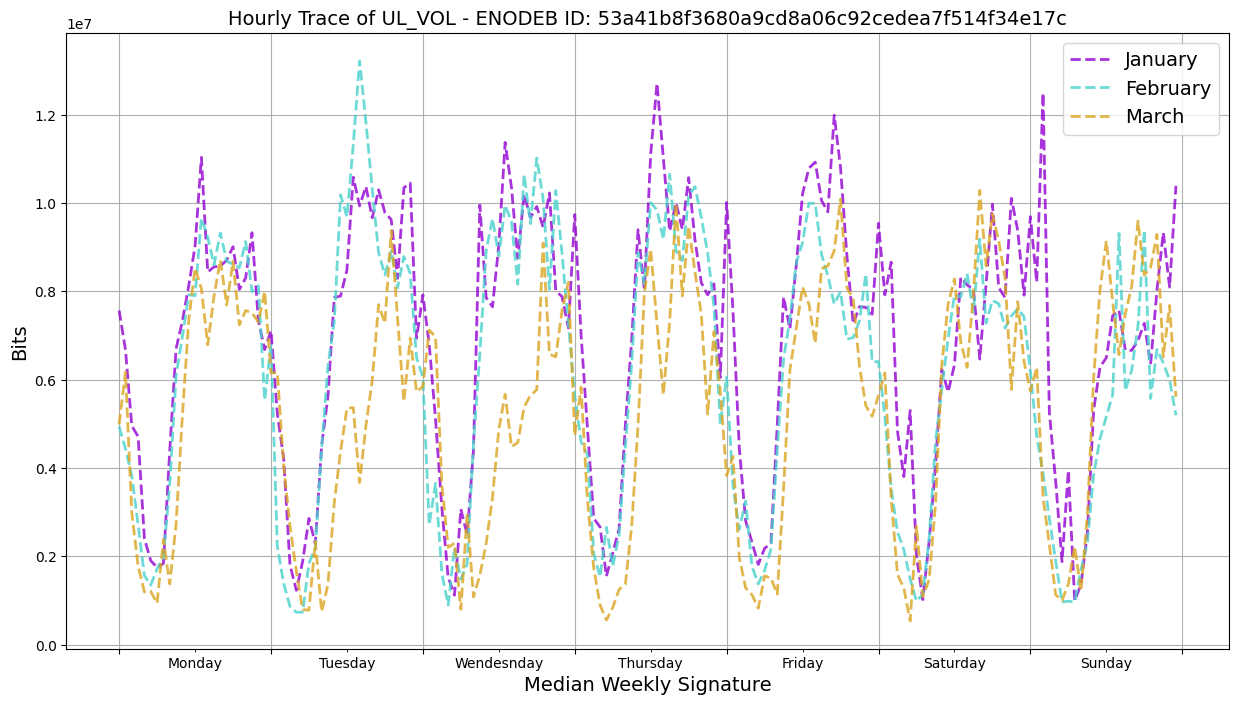

In [287]:
#Plotting of the uplink for the same enodeB

enodeb_id = '53a41b8f3680a9cd8a06c92cedea7f514f34e17c'
ref_Jan = pd.DataFrame()
ref_Feb = pd.DataFrame()
ref_Mar = pd.DataFrame()
# Sort hourly samples by date
for j in statistic_January[i]:
  ref_Jan = pd.concat([ref_Jan,statistic_January_uplink[enodeb_id][j]['Median']],ignore_index=True)

for j in statistic_February[i]:
  ref_Feb = pd.concat([ref_Feb,statistic_February_uplink[enodeb_id][j]['Median']],ignore_index=True)

for j in statistic_March[i]:
  ref_Mar = pd.concat([ref_Mar,statistic_March_uplink[enodeb_id][j]['Median']],ignore_index=True)
# open new figure
fig, ax = plt.subplots(figsize=(15,8))

# plot data
ax.plot(list(range(0,len(ref_Jan))),ref_Jan, linestyle='--', lw=2, color='darkviolet', label ='January', alpha=.8)
ax.plot(list(range(0,len(ref_Feb))),ref_Feb, linestyle='--', lw=2, color='mediumturquoise', label ='February', alpha=.8)
ax.plot(list(range(0,len(ref_Mar))),ref_Mar, linestyle='--', lw=2, color='goldenrod', label ='March', alpha=.8)

days = ['Monday','Tuesday', 'Wendesnday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Set plotting options
plt.yticks(color='black')
plt.xticks(color='black', ticks = [0,24,48,72,96,120,144,168])
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_locator(ticker.FixedLocator([12, 36, 60, 84, 108, 132, 156]))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(days))
plt.grid(1)
plt.setp( ax.xaxis.get_majorticklabels(), rotation_mode="anchor")
plt.xlabel('Median Weekly Signature', color='black', fontsize=14)
plt.ylabel('Bits', color='black', fontsize=14) # unit of measure depends on the considered KPI
plt.legend(loc="upper right", fontsize = 14)
plt.title('Hourly Trace of '+'UL_VOL'+' - ENODEB ID: %s'%enodeb_id, fontsize=14)
plt.show()

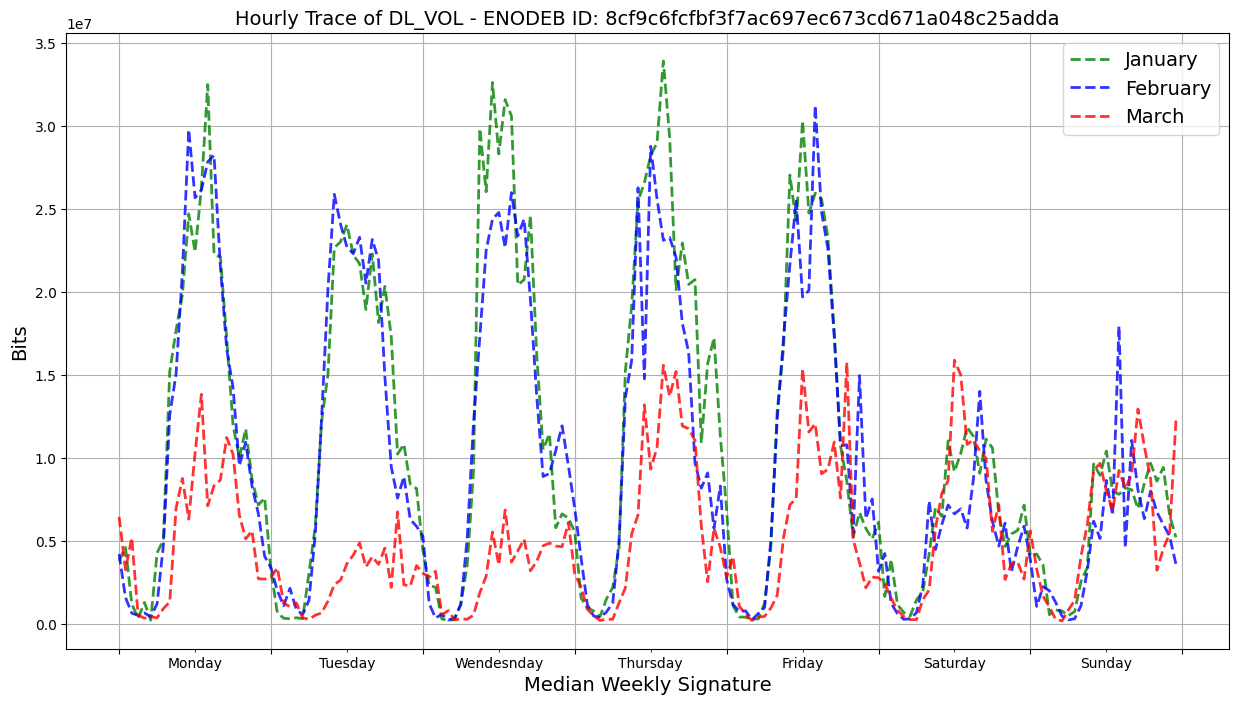

In [289]:
#We chose this EnodeB for Non residential; the traffic in the weekend is clearly less then in the other days

enodeb_id = '8cf9c6fcfbf3f7ac697ec673cd671a048c25adda'
ref_Jan = pd.DataFrame()
ref_Feb = pd.DataFrame()
ref_Mar = pd.DataFrame()
# Sort hourly samples by date
for j in statistic_January[i]:
  ref_Jan = pd.concat([ref_Jan,statistic_January[enodeb_id][j]['Median']],ignore_index=True)

for j in statistic_February[i]:
  ref_Feb = pd.concat([ref_Feb,statistic_February[enodeb_id][j]['Median']],ignore_index=True)

for j in statistic_March[i]:
  ref_Mar = pd.concat([ref_Mar,statistic_March[enodeb_id][j]['Median']],ignore_index=True)
# open new figure
fig, ax = plt.subplots(figsize=(15,8))

# plot data
ax.plot(list(range(0,len(ref_Jan))),ref_Jan, linestyle='--', lw=2, color='g', label ='January', alpha=.8)
ax.plot(list(range(0,len(ref_Feb))),ref_Feb, linestyle='--', lw=2, color='b', label ='February', alpha=.8)
ax.plot(list(range(0,len(ref_Mar))),ref_Mar, linestyle='--', lw=2, color='r', label ='March', alpha=.8)

days = ['Monday','Tuesday', 'Wendesnday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Set plotting options
plt.yticks(color='black')
plt.xticks(color='black', ticks = [0,24,48,72,96,120,144,168])
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_locator(ticker.FixedLocator([12, 36, 60, 84, 108, 132, 156]))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(days))
plt.grid(1)
plt.setp( ax.xaxis.get_majorticklabels(), rotation_mode="anchor")
plt.xlabel('Median Weekly Signature', color='black', fontsize=14)
plt.ylabel('Bits', color='black', fontsize=14) # unit of measure depends on the considered KPI
plt.legend(loc="upper right", fontsize = 14)
plt.title('Hourly Trace of '+'DL_VOL'+' - ENODEB ID: %s'%enodeb_id, fontsize=14)
plt.show()

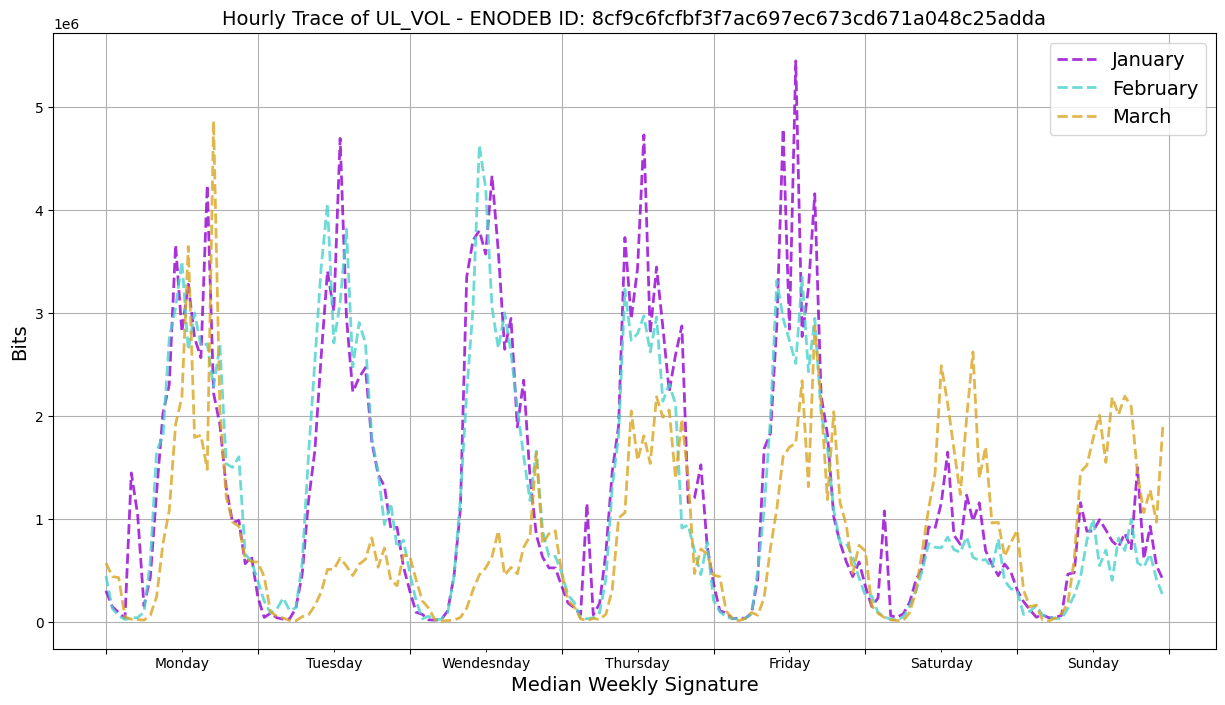

In [290]:
#Uplink plot

enodeb_id = '8cf9c6fcfbf3f7ac697ec673cd671a048c25adda'
ref_Jan = pd.DataFrame()
ref_Feb = pd.DataFrame()
ref_Mar = pd.DataFrame()
# Sort hourly samples by date
for j in statistic_January[i]:
  ref_Jan = pd.concat([ref_Jan,statistic_January_uplink[enodeb_id][j]['Median']],ignore_index=True)

for j in statistic_February[i]:
  ref_Feb = pd.concat([ref_Feb,statistic_February_uplink[enodeb_id][j]['Median']],ignore_index=True)

for j in statistic_March[i]:
  ref_Mar = pd.concat([ref_Mar,statistic_March_uplink[enodeb_id][j]['Median']],ignore_index=True)
# open new figure
fig, ax = plt.subplots(figsize=(15,8))

# plot data
ax.plot(list(range(0,len(ref_Jan))),ref_Jan, linestyle='--', lw=2, color='darkviolet', label ='January', alpha=.8)
ax.plot(list(range(0,len(ref_Feb))),ref_Feb, linestyle='--', lw=2, color='mediumturquoise', label ='February', alpha=.8)
ax.plot(list(range(0,len(ref_Mar))),ref_Mar, linestyle='--', lw=2, color='goldenrod', label ='March', alpha=.8)

days = ['Monday','Tuesday', 'Wendesnday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Set plotting options
plt.yticks(color='black')
plt.xticks(color='black', ticks = [0,24,48,72,96,120,144,168])
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_locator(ticker.FixedLocator([12, 36, 60, 84, 108, 132, 156]))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(days))
plt.grid(1)
plt.setp( ax.xaxis.get_majorticklabels(), rotation_mode="anchor")
plt.xlabel('Median Weekly Signature', color='black', fontsize=14)
plt.ylabel('Bits', color='black', fontsize=14) # unit of measure depends on the considered KPI
plt.legend(loc="upper right", fontsize = 14)
plt.title('Hourly Trace of '+'UL_VOL'+' - ENODEB ID: %s'%enodeb_id, fontsize=14)
plt.show()

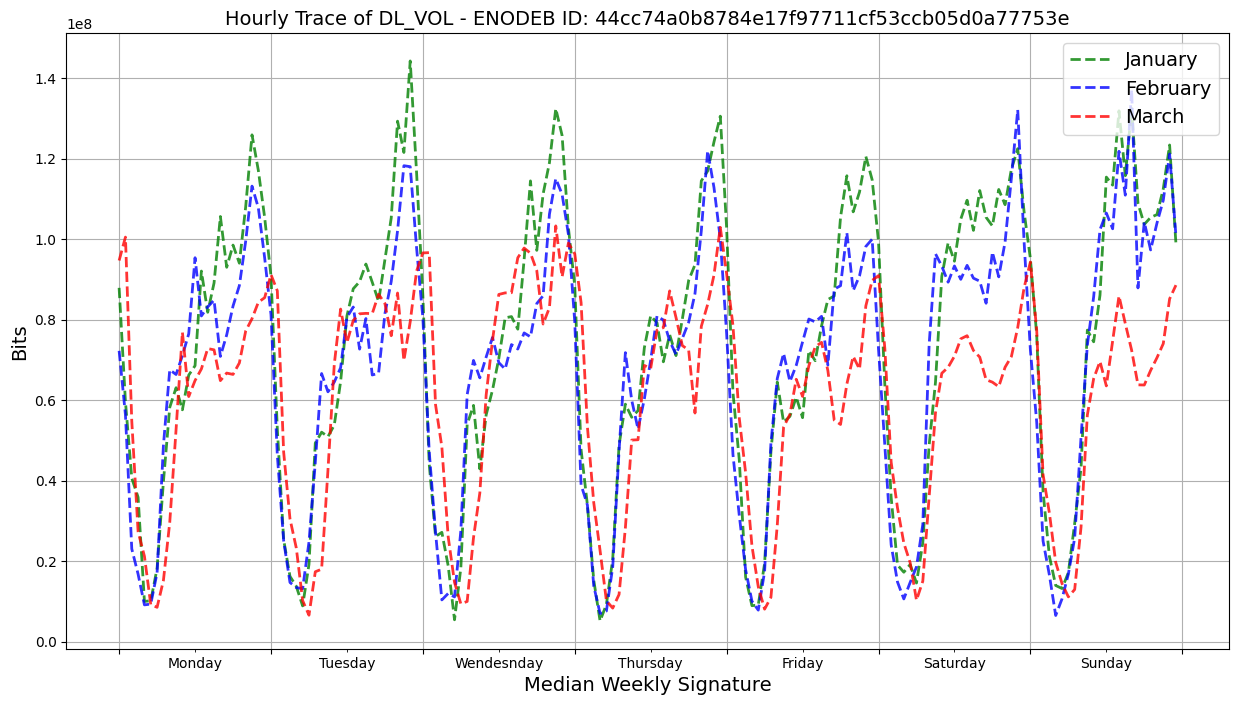

In [284]:
#We chose this EnodeB for residential; the traffic is really consistent always

enodeb_id = '44cc74a0b8784e17f97711cf53ccb05d0a77753e'
ref_Jan = pd.DataFrame()
ref_Feb = pd.DataFrame()
ref_Mar = pd.DataFrame()
# Sort hourly samples by date
for j in statistic_January[i]:
  ref_Jan = pd.concat([ref_Jan,statistic_January[enodeb_id][j]['Median']],ignore_index=True)

for j in statistic_February[i]:
  ref_Feb = pd.concat([ref_Feb,statistic_February[enodeb_id][j]['Median']],ignore_index=True)

for j in statistic_March[i]:
  ref_Mar = pd.concat([ref_Mar,statistic_March[enodeb_id][j]['Median']],ignore_index=True)
# open new figure
fig, ax = plt.subplots(figsize=(15,8))

# plot data
ax.plot(list(range(0,len(ref_Jan))),ref_Jan, linestyle='--', lw=2, color='g', label ='January', alpha=.8)
ax.plot(list(range(0,len(ref_Feb))),ref_Feb, linestyle='--', lw=2, color='b', label ='February', alpha=.8)
ax.plot(list(range(0,len(ref_Mar))),ref_Mar, linestyle='--', lw=2, color='r', label ='March', alpha=.8)

days = ['Monday','Tuesday', 'Wendesnday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Set plotting options
plt.yticks(color='black')
plt.xticks(color='black', ticks = [0,24,48,72,96,120,144,168])
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_locator(ticker.FixedLocator([12, 36, 60, 84, 108, 132, 156]))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(days))
plt.grid(1)
plt.setp( ax.xaxis.get_majorticklabels(), rotation_mode="anchor")
plt.xlabel('Median Weekly Signature', color='black', fontsize=14)
plt.ylabel('Bits', color='black', fontsize=14) # unit of measure depends on the considered KPI
plt.legend(loc="upper right", fontsize = 14)
plt.title('Hourly Trace of '+'DL_VOL'+' - ENODEB ID: %s'%enodeb_id, fontsize=14)
plt.show()

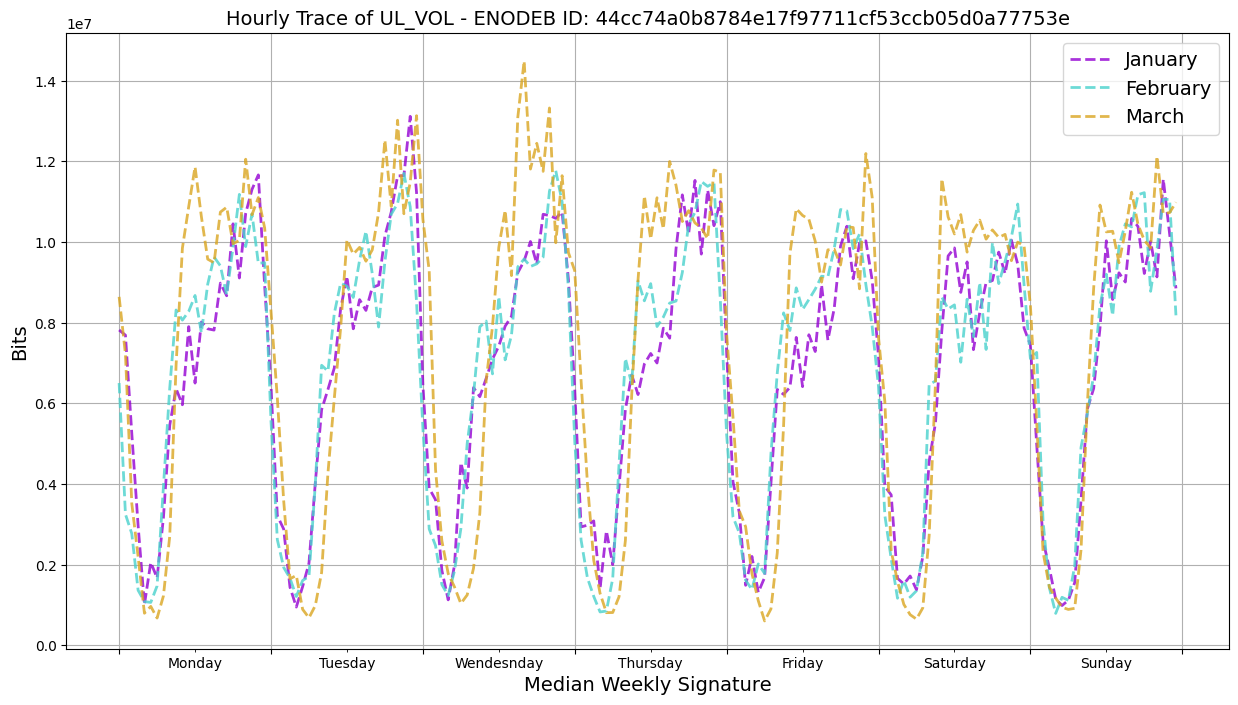

In [283]:
#Uplink

enodeb_id = '44cc74a0b8784e17f97711cf53ccb05d0a77753e'
ref_Jan = pd.DataFrame()
ref_Feb = pd.DataFrame()
ref_Mar = pd.DataFrame()
# Sort hourly samples by date
for j in statistic_January[i]:
  ref_Jan = pd.concat([ref_Jan,statistic_January_uplink[enodeb_id][j]['Median']],ignore_index=True)

for j in statistic_February[i]:
  ref_Feb = pd.concat([ref_Feb,statistic_February_uplink[enodeb_id][j]['Median']],ignore_index=True)

for j in statistic_March[i]:
  ref_Mar = pd.concat([ref_Mar,statistic_March_uplink[enodeb_id][j]['Median']],ignore_index=True)
# open new figure
fig, ax = plt.subplots(figsize=(15,8))

# plot data
ax.plot(list(range(0,len(ref_Jan))),ref_Jan, linestyle='--', lw=2, color='darkviolet', label ='January', alpha=.8)
ax.plot(list(range(0,len(ref_Feb))),ref_Feb, linestyle='--', lw=2, color='mediumturquoise', label ='February', alpha=.8)
ax.plot(list(range(0,len(ref_Mar))),ref_Mar, linestyle='--', lw=2, color='goldenrod', label ='March', alpha=.8)

days = ['Monday','Tuesday', 'Wendesnday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# Set plotting options
plt.yticks(color='black')
plt.xticks(color='black', ticks = [0,24,48,72,96,120,144,168])
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_locator(ticker.FixedLocator([12, 36, 60, 84, 108, 132, 156]))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(days))
plt.grid(1)
plt.setp( ax.xaxis.get_majorticklabels(), rotation_mode="anchor")
plt.xlabel('Median Weekly Signature', color='black', fontsize=14)
plt.ylabel('Bits', color='black', fontsize=14) # unit of measure depends on the considered KPI
plt.legend(loc="upper right", fontsize = 14)
plt.title('Hourly Trace of '+'UL_VOL'+' - ENODEB ID: %s'%enodeb_id, fontsize=14)
plt.show()

In [298]:
#Plotting of the three cells; the position for each one makes a lot of sense

loc = pd.DataFrame()

loc = locations[(locations['ENODEB_ID'] == '8cf9c6fcfbf3f7ac697ec673cd671a048c25adda')]
loc = pd.concat([loc,locations[(locations['ENODEB_ID'] == '44cc74a0b8784e17f97711cf53ccb05d0a77753e')]],ignore_index=True)
loc = pd.concat([loc,locations[(locations['ENODEB_ID'] == '53a41b8f3680a9cd8a06c92cedea7f514f34e17c')]],ignore_index=True)

px.set_mapbox_access_token("pk.eyJ1IjoiY2hpYXJhZHJhZ2hpbmkiLCJhIjoiY2tzdWhlY2YyMGN2czJwcHV2dWt5cXFlcCJ9.bzW271vEA_agKVY5K2FvGA")

fig = px.scatter_mapbox(loc, lat="LAT_Y", lon="LONG_X", zoom=10, hover_data =[loc.ENODEB_ID], color = 'ENODEB_ID', color_discrete_map={'8cf9c6fcfbf3f7ac697ec673cd671a048c25adda':'darkblue',
                                                                                                                                       '44cc74a0b8784e17f97711cf53ccb05d0a77753e': 'violet',
                                                                                                                                       '53a41b8f3680a9cd8a06c92cedea7f514f34e17c': 'orange'}
)
fig.show()


In [343]:
#Plot of all the locations, with the color for the corresponding categories

locations_update = locations[['ENODEB_ID','LAT_Y','LONG_X']]
locations_update = locations_update.drop_duplicates('ENODEB_ID')
loc_type = []
for i in locations_update['ENODEB_ID']:
  if i in list_zero:
    loc_type.append('0')
  elif i in list_one:
    loc_type.append('1')
  elif i in list_two:
    loc_type.append('2')
locations_update.insert(1, 'Type', loc_type, True)

px.set_mapbox_access_token("pk.eyJ1IjoiY2hpYXJhZHJhZ2hpbmkiLCJhIjoiY2tzdWhlY2YyMGN2czJwcHV2dWt5cXFlcCJ9.bzW271vEA_agKVY5K2FvGA")

fig = px.scatter_mapbox(locations_update, lat="LAT_Y", lon="LONG_X", zoom=10, hover_data =[locations_update.ENODEB_ID], color = 'Type', color_discrete_map={ '0' :'darkblue',
                                                                                                                                       '1': 'violet',
                                                                                                                                       '2' : 'orange'}
)
fig.show()

